# Explorative Analyses

In [1]:
import os
import time
import pysal
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sb
import matplotlib.pyplot as plt
from pysal.model import spreg
from esda.moran import Moran

The following helper functions are loaded from `./analysis.py` and will be further used to perform the data filtering.
- `filter_by_EOI`: returns a Pandas DataFrame with geometry by filtering according to an Event Of Interest (EOI) (CAMEO code associated to the `EventBaseCode`.
- `filter_by_country`: returns a Pandas DataFrame with geometry by filtering according all records that were recorded to occur within a given country's borders.
- `extracting_timeseries`: perform the extraction of the timeseries corresponding to the amount of "Riot" related protest recorded in the period under examination for all countries.


In [2]:
# custom import
from analysis import *

Defining the corresponding path to files and `BATCH_SIZE` which encodes the amount of records to be loaded while performing the whole time data records reading. The higher the amount of rows to be loaded the faster the process, the more expensive the RAM usage.

In [3]:
DATAPATH    = "./records"
GEOM_FILE   = "./Africa_Boundaries-shp/"
GEOMETRIES  = "./Africa_Boundaries-shp/Africa_Boundaries.dbf"
RECORD_FILE = "./data/records_2020_2023.parquet"
BATCH_SIZE  = 1*10**4 

The `.dbf` file is loaded as follows:

In [4]:
# loading geometry gdf
geometries = load_geometries(GEOMETRIES)
geometries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# filtering all events by cameo codes
f203 = filter_by_EOI(RECORD_FILE, 203)
f203.head()

In [ ]:
# filtering all events by a single country
fAlgeria = filter_by_country(RECORD_FILE, "Algeria")
fAlgeria.head()

# Timeseries extracting

Performing timeseries extraction for CAMEO `EventRootCode`  $\in$ `[5,6,7,10,12,13,14,19,20]`.


In [ ]:
for c in [5,6,7,10,12,13,14,19,20]:
    extracting_timeseries(RECORD_FILE, geometries.NAME_0.values, [c])

Performing timeseries filtering:
Filtering by country: Angola
Elapsed (sec): 14.509
Filtering by country: French Southern Territories


# Protest/riots events: CAMEO `EventRootCode=14`
Displaying the frequency over time of those countries that were found to have the highest amount of protests referring to the CAMEO `EventRootCode=14`.

In [6]:
timeseries = pd.read_parquet("./data/timeseries_cameo14.parquet")
timeseries["Year"]  = timeseries.Date.apply(lambda x: str(x)[0:4])
timeseries["Month"] = timeseries.Date.apply(lambda x: str(x)[4:6])
timeseries["Day"]   = timeseries.Date.apply(lambda x: str(x)[6:8])
timeseries["Date"]  = timeseries.Date.transform(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

Overall sum of all riots event for all countries regardless the period.

In [7]:
# extracting those countries that present the higher amount of events in the whole period
gb = timeseries.groupby("NAME_0")["count"].sum()
riot = pd.DataFrame({"count": gb}).sort_values(by="count", ascending=False)

Choroplet of amount of riots that occurred in the 4 year span 

In [8]:
gb = timeseries.groupby(["NAME_0", "Year"])["count"].sum().to_frame()

## Time series plotting (within countries normalization)

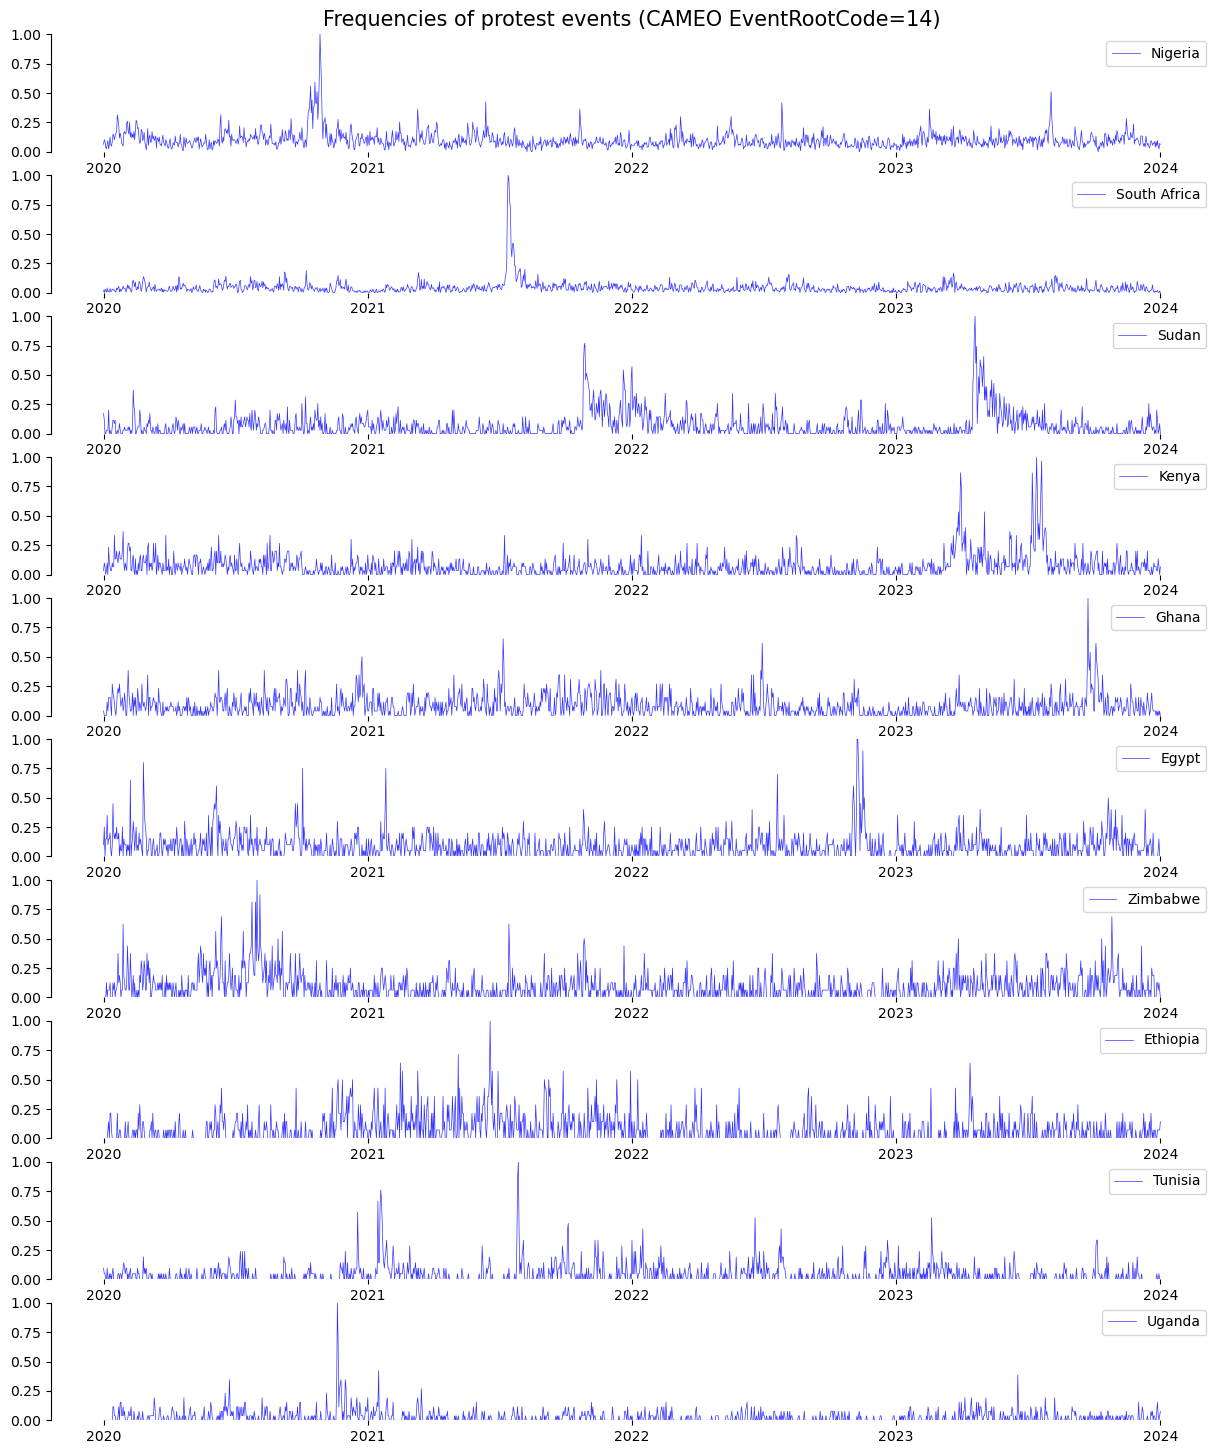

In [9]:
import matplotlib as mpl

mpl.rcParams['axes.spines.left']   = True
mpl.rcParams['axes.spines.right']  = False
mpl.rcParams['axes.spines.top']    = False
mpl.rcParams['axes.spines.bottom'] = False

country_names = riot[0:10].index 

fig = plt.figure(figsize=(15,18))

for i,country in enumerate(country_names):
    ax = plt.subplot(10,1,i+1)
    series = timeseries[timeseries.NAME_0 == country]["count"]
    ax.plot(series/series.max(), linewidth=0.5, alpha = 0.8, label = country, color = "blue")
    ax.set_ylim((0.,1.))
    ax.set_xticks((range(0, series.shape[0], series.shape[0]//4)),labels = ["2020", "2021", "2022", "2023", "2024"])
    ax.legend()
    if i==0:
        ax.set_title("Frequencies of protest events (CAMEO EventRootCode=14)", fontsize=15)
plt.savefig("./pics/riot_frequencies.png")

## Choropleth map visualization.

In [10]:
geometries = gpd.read_file("./Africa_Boundaries-shp/")
gbmean = timeseries.groupby(["NAME_0", "Year"])["count"].mean().to_frame().reset_index()

In [11]:
gbmean

NAME_0  Year     count
0     Algeria  2020  0.819672
1     Algeria  2021  0.830137
2     Algeria  2022  0.260274
3     Algeria  2023  0.279452
4      Angola  2020  0.226776
..        ...   ...       ...
223    Zambia  2023  0.230137
224  Zimbabwe  2020  2.202186
225  Zimbabwe  2021  1.197260
226  Zimbabwe  2022  1.032877
227  Zimbabwe  2023  1.739726

[228 rows x 3 columns]

In [12]:
year = "2020"
merged = pd.merge(geometries, gbmean[gbmean.Year==year], how="left", on="NAME_0").rename(columns={"count":"value"})
gbmean["count"].max()

16.494535519125684

Saving image for 2020 ...
Saving image for 2021 ...
Saving image for 2022 ...
Saving image for 2023 ...


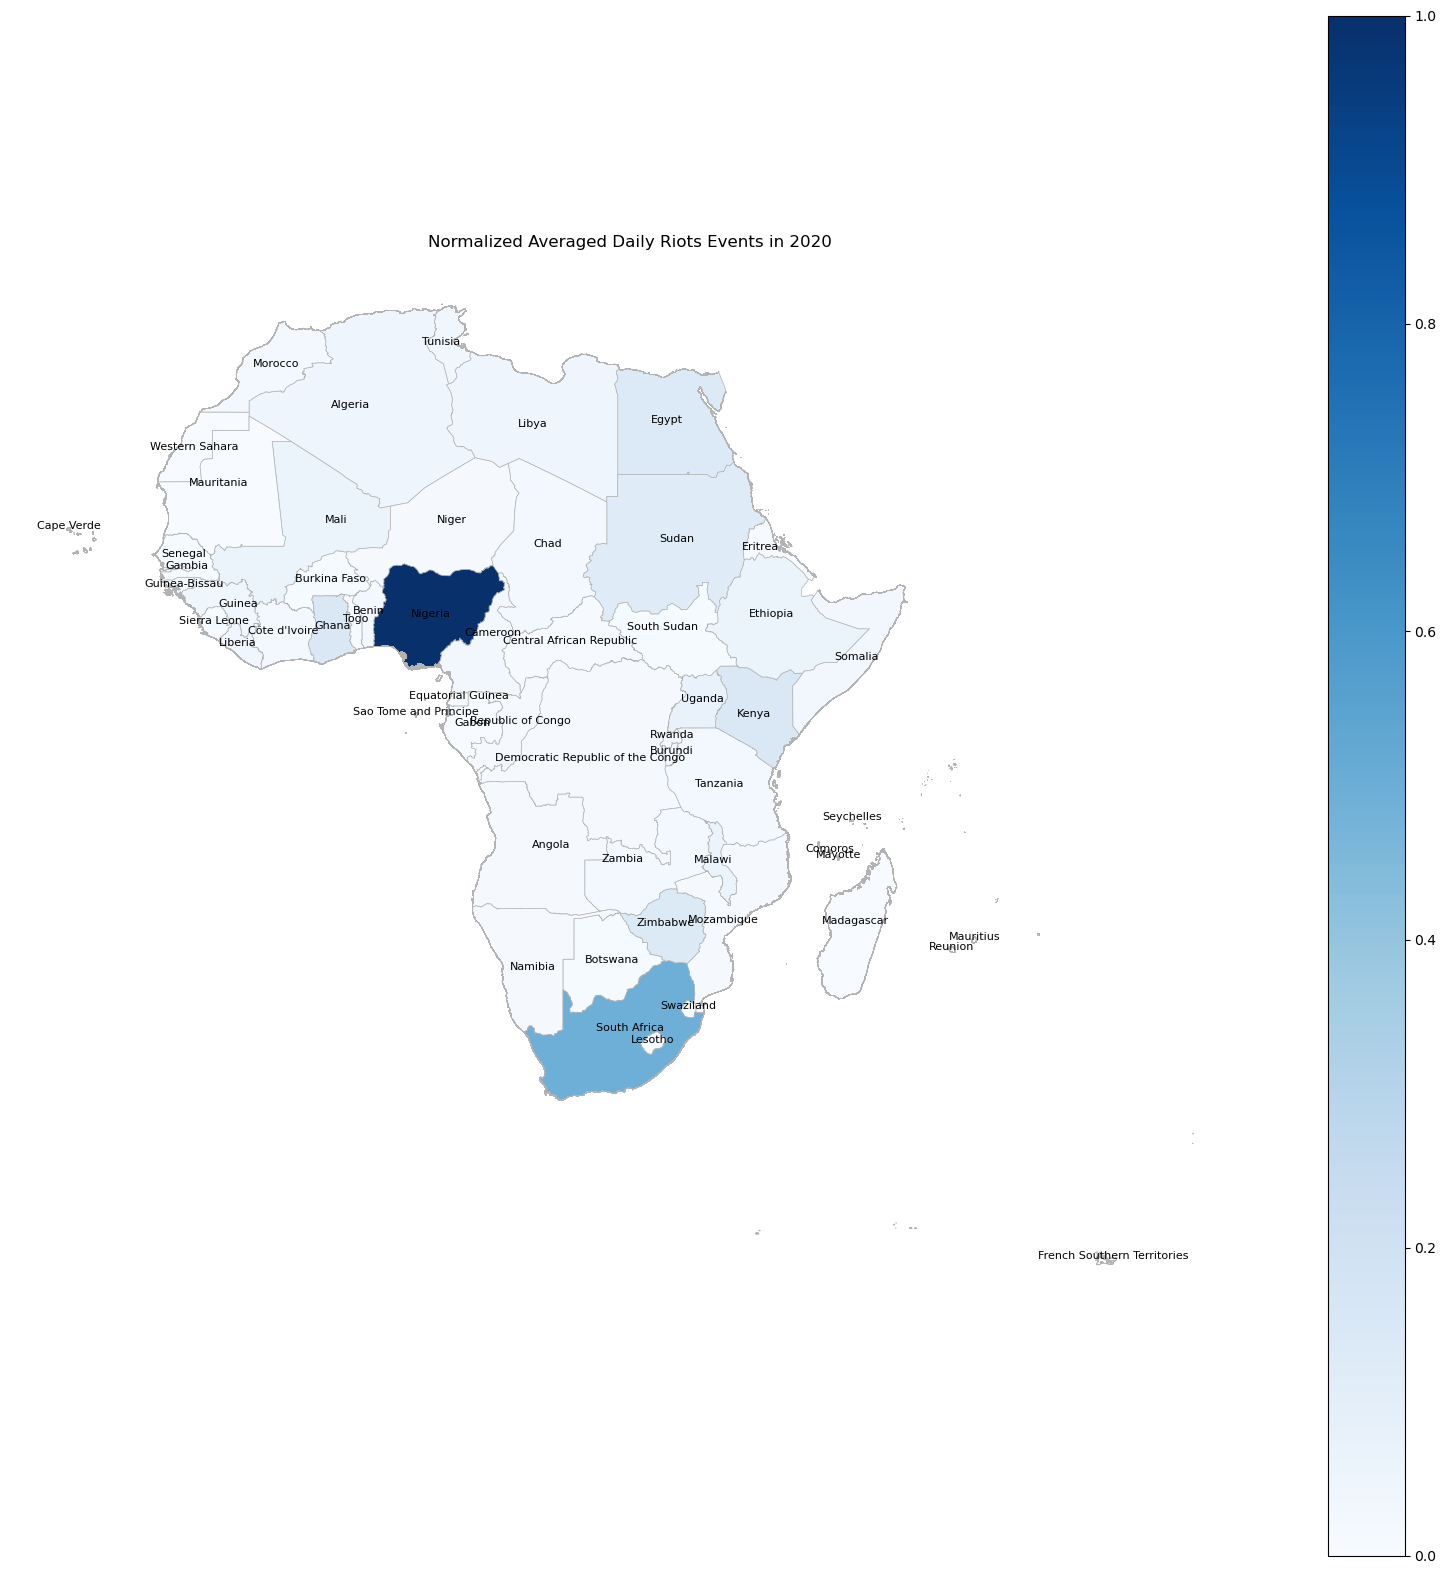

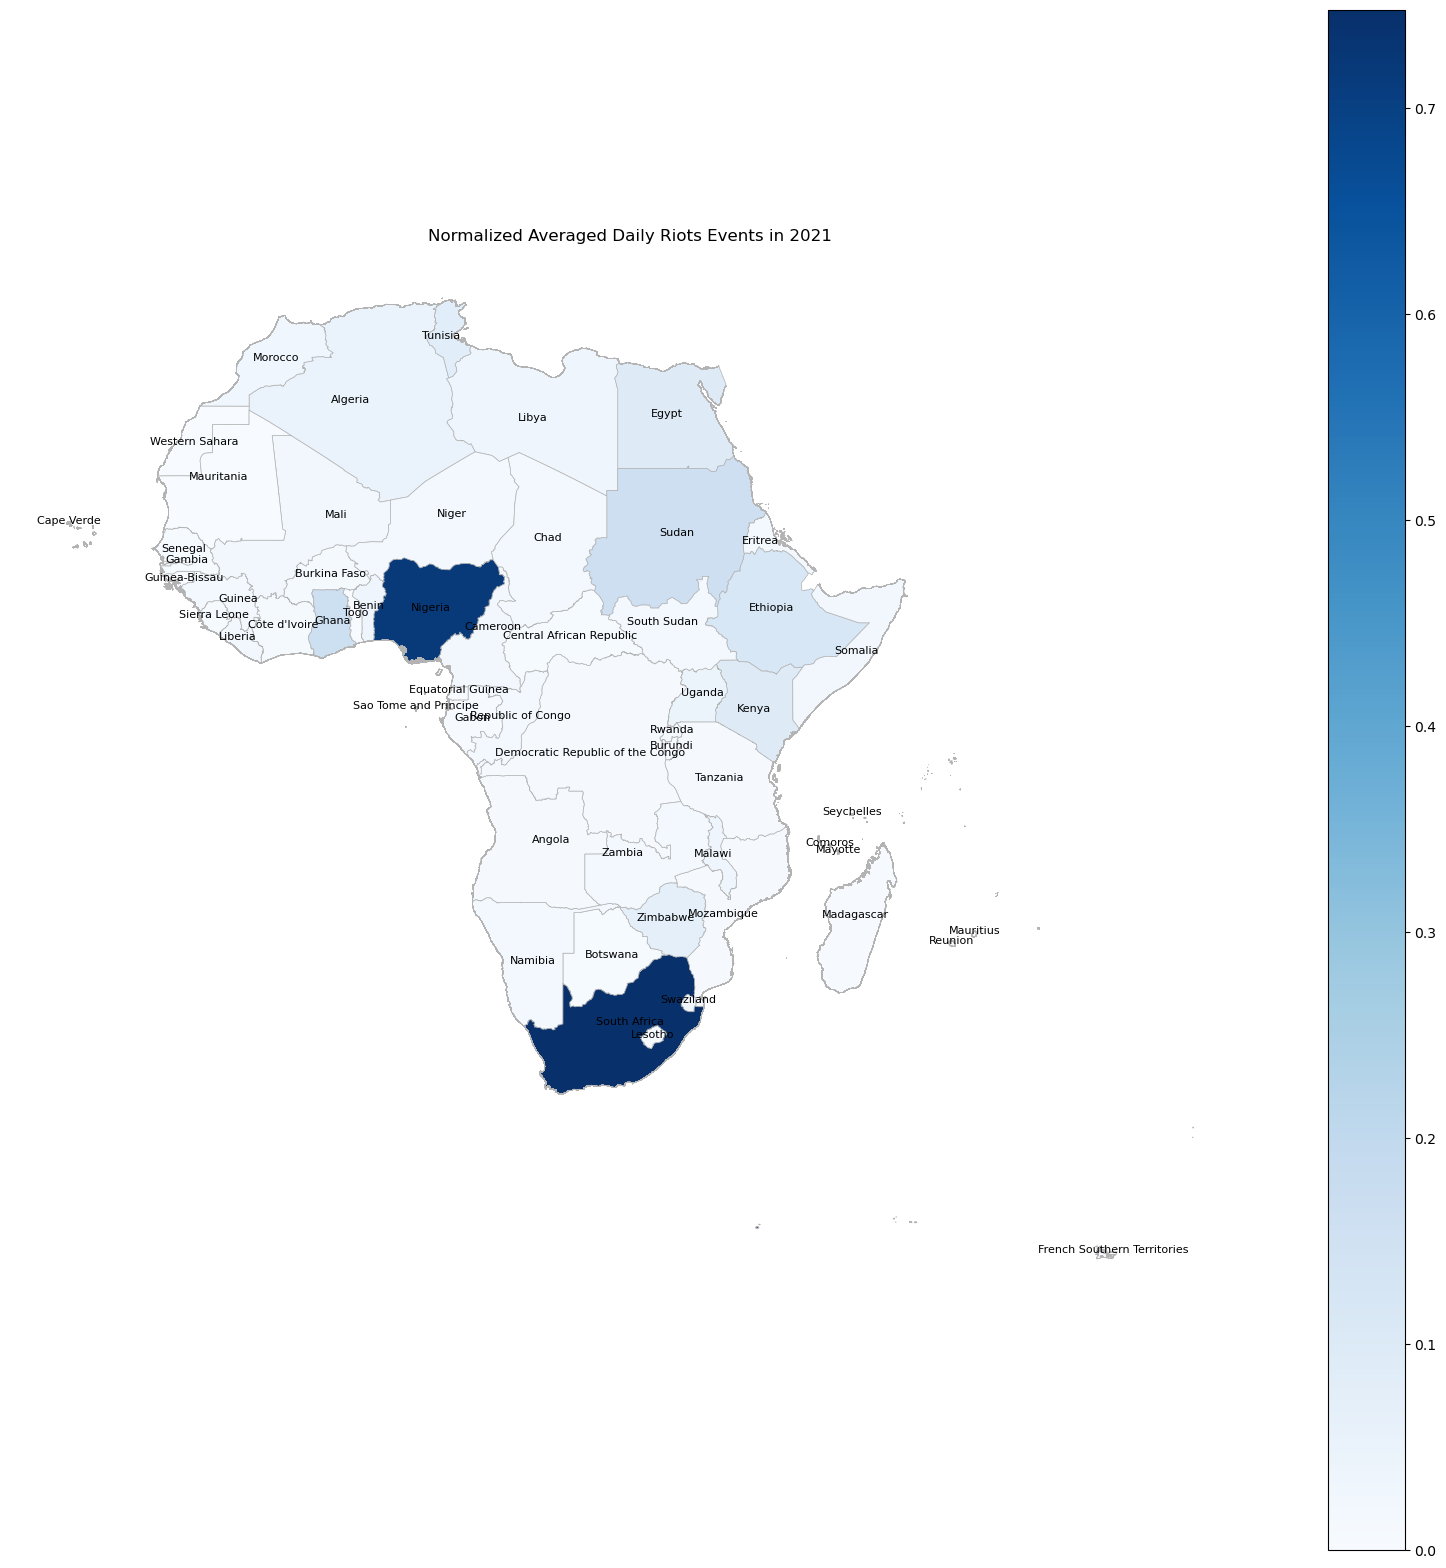

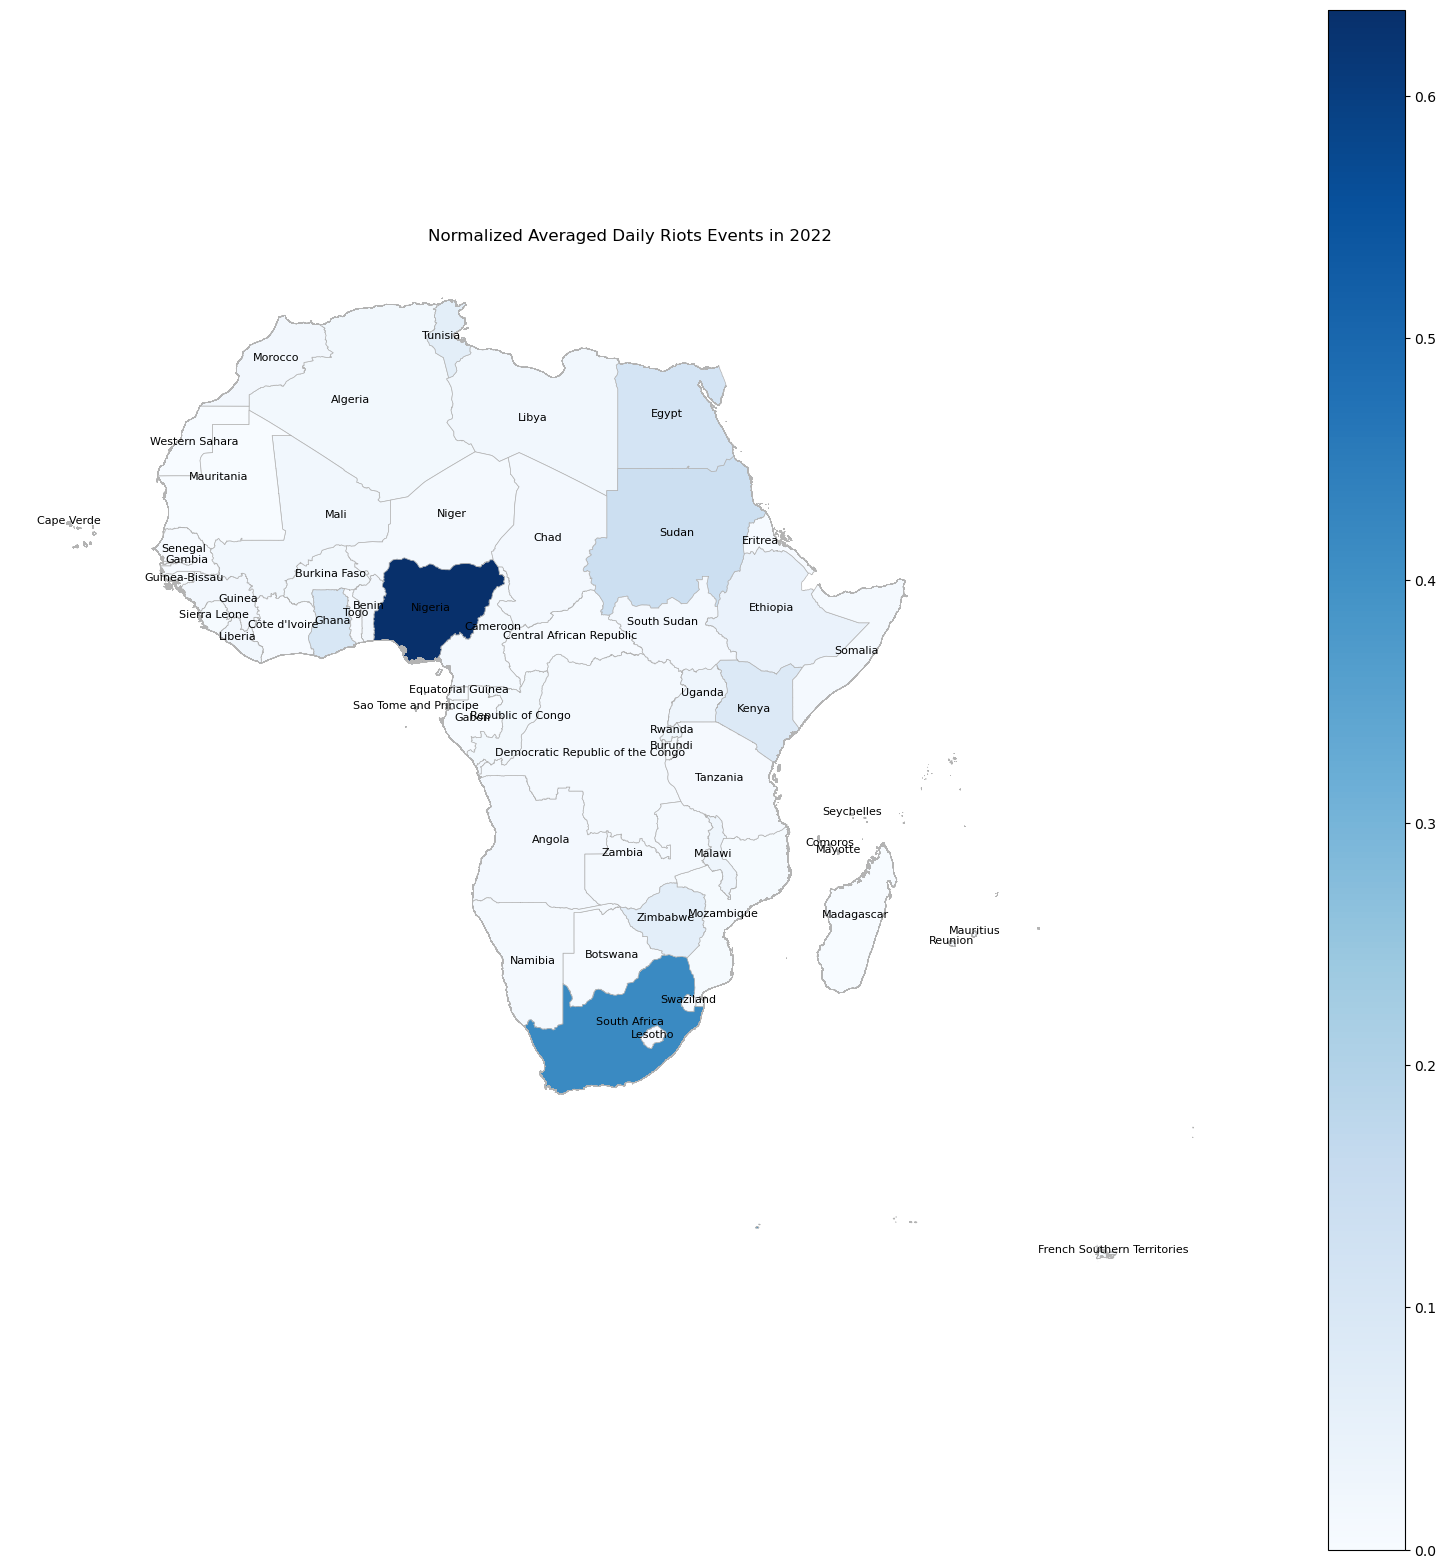

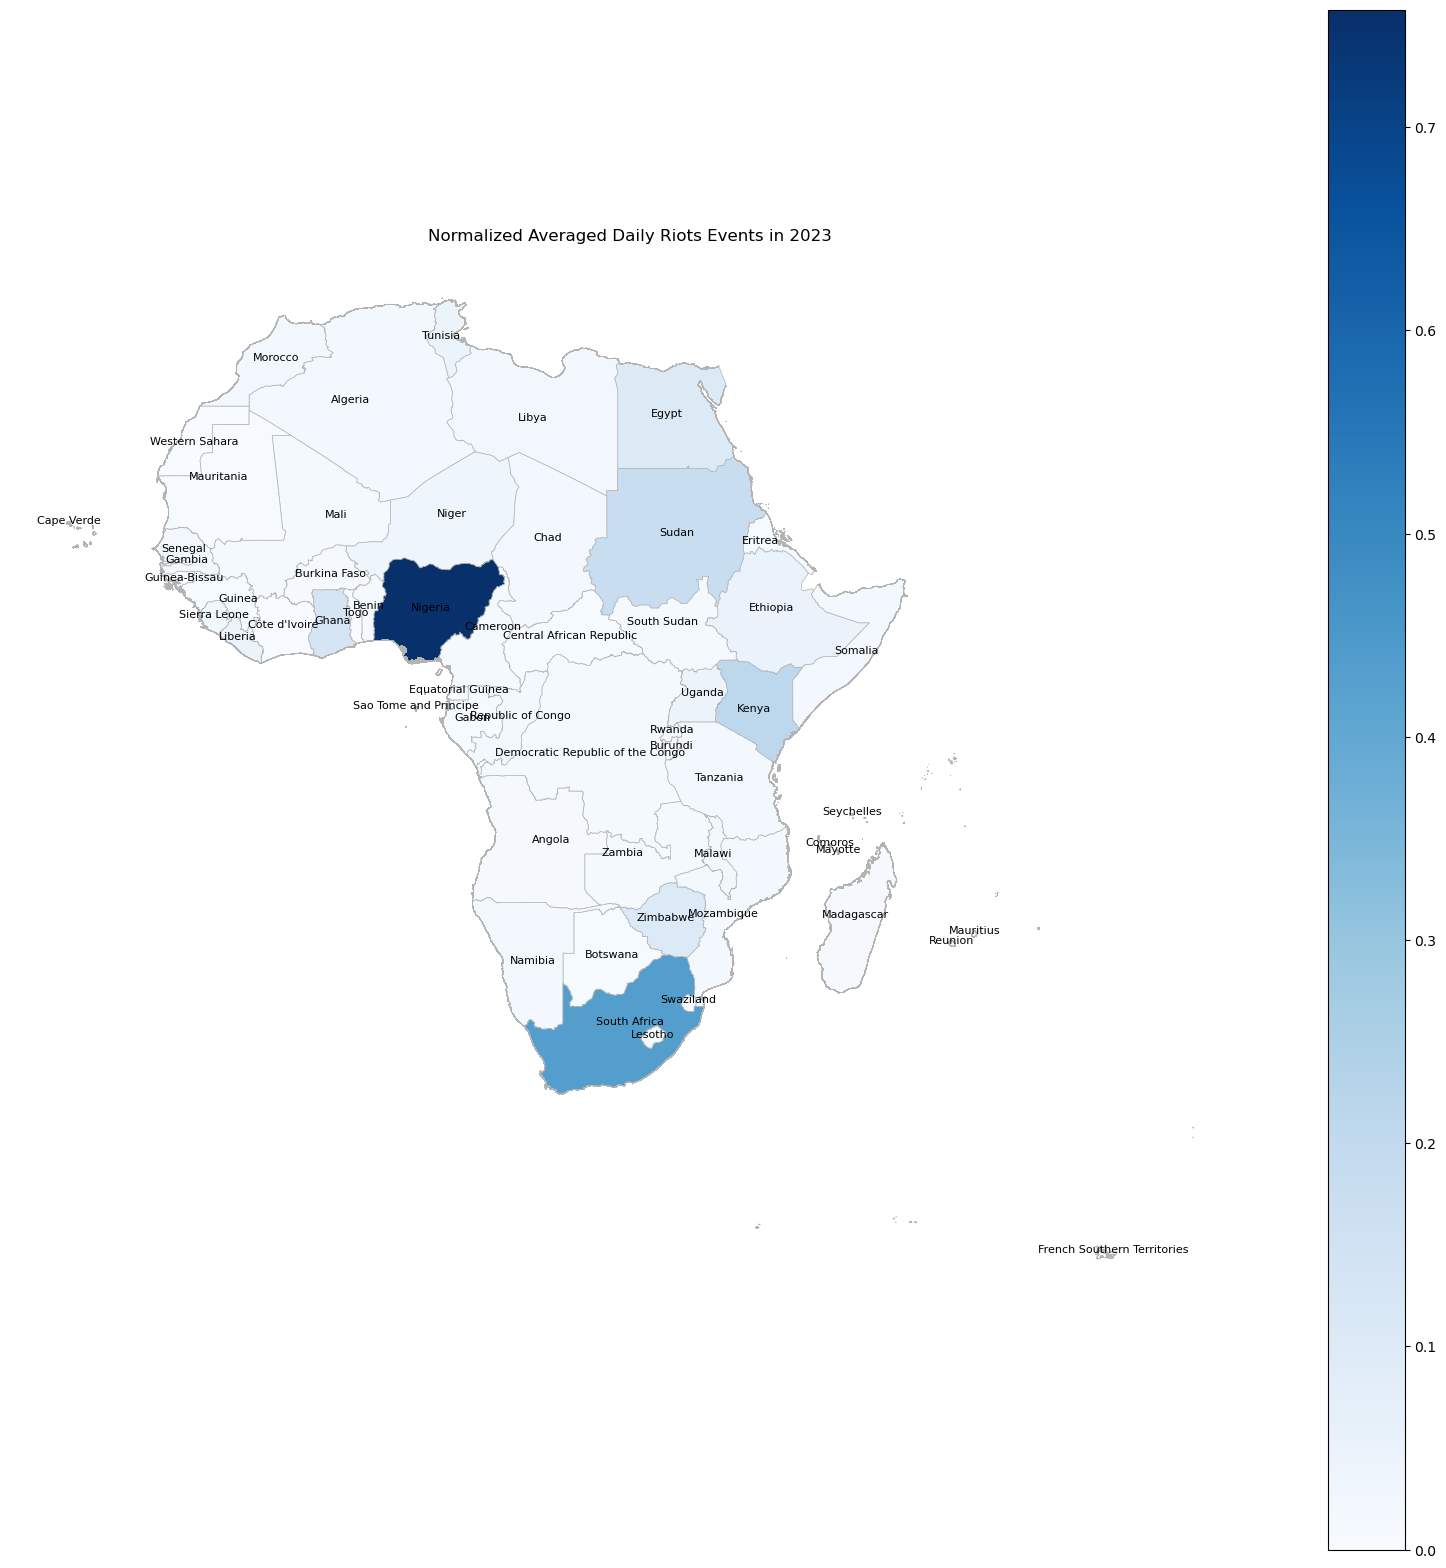

In [13]:
for year in ["2020","2021","2022","2023"]:
    print(f"Saving image for {year} ...")
    fig, ax = plt.subplots(1, figsize=(20,20))
    merged = pd.merge(geometries, gbmean[gbmean.Year==year], how="left", on="NAME_0").rename(columns={"count":"value"})
    merged.value = merged.value/gbmean["count"].max()
    
    merged.plot(column='value', cmap='Blues', linewidth=0.5, ax=ax, edgecolor='0.7',legend = True);
    merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        plt.annotate(row['NAME_0'], xy=row['coords'], horizontalalignment='center', fontsize=8)
    
    ax.axis('off')
    ax.set_title(f"Normalized Averaged Daily Riots Events in {year}")
    plt.savefig(f"./pics/avg_riots_{year}.png")

Saving image for 2020 ...
Saving image for 2021 ...
Saving image for 2022 ...
Saving image for 2023 ...


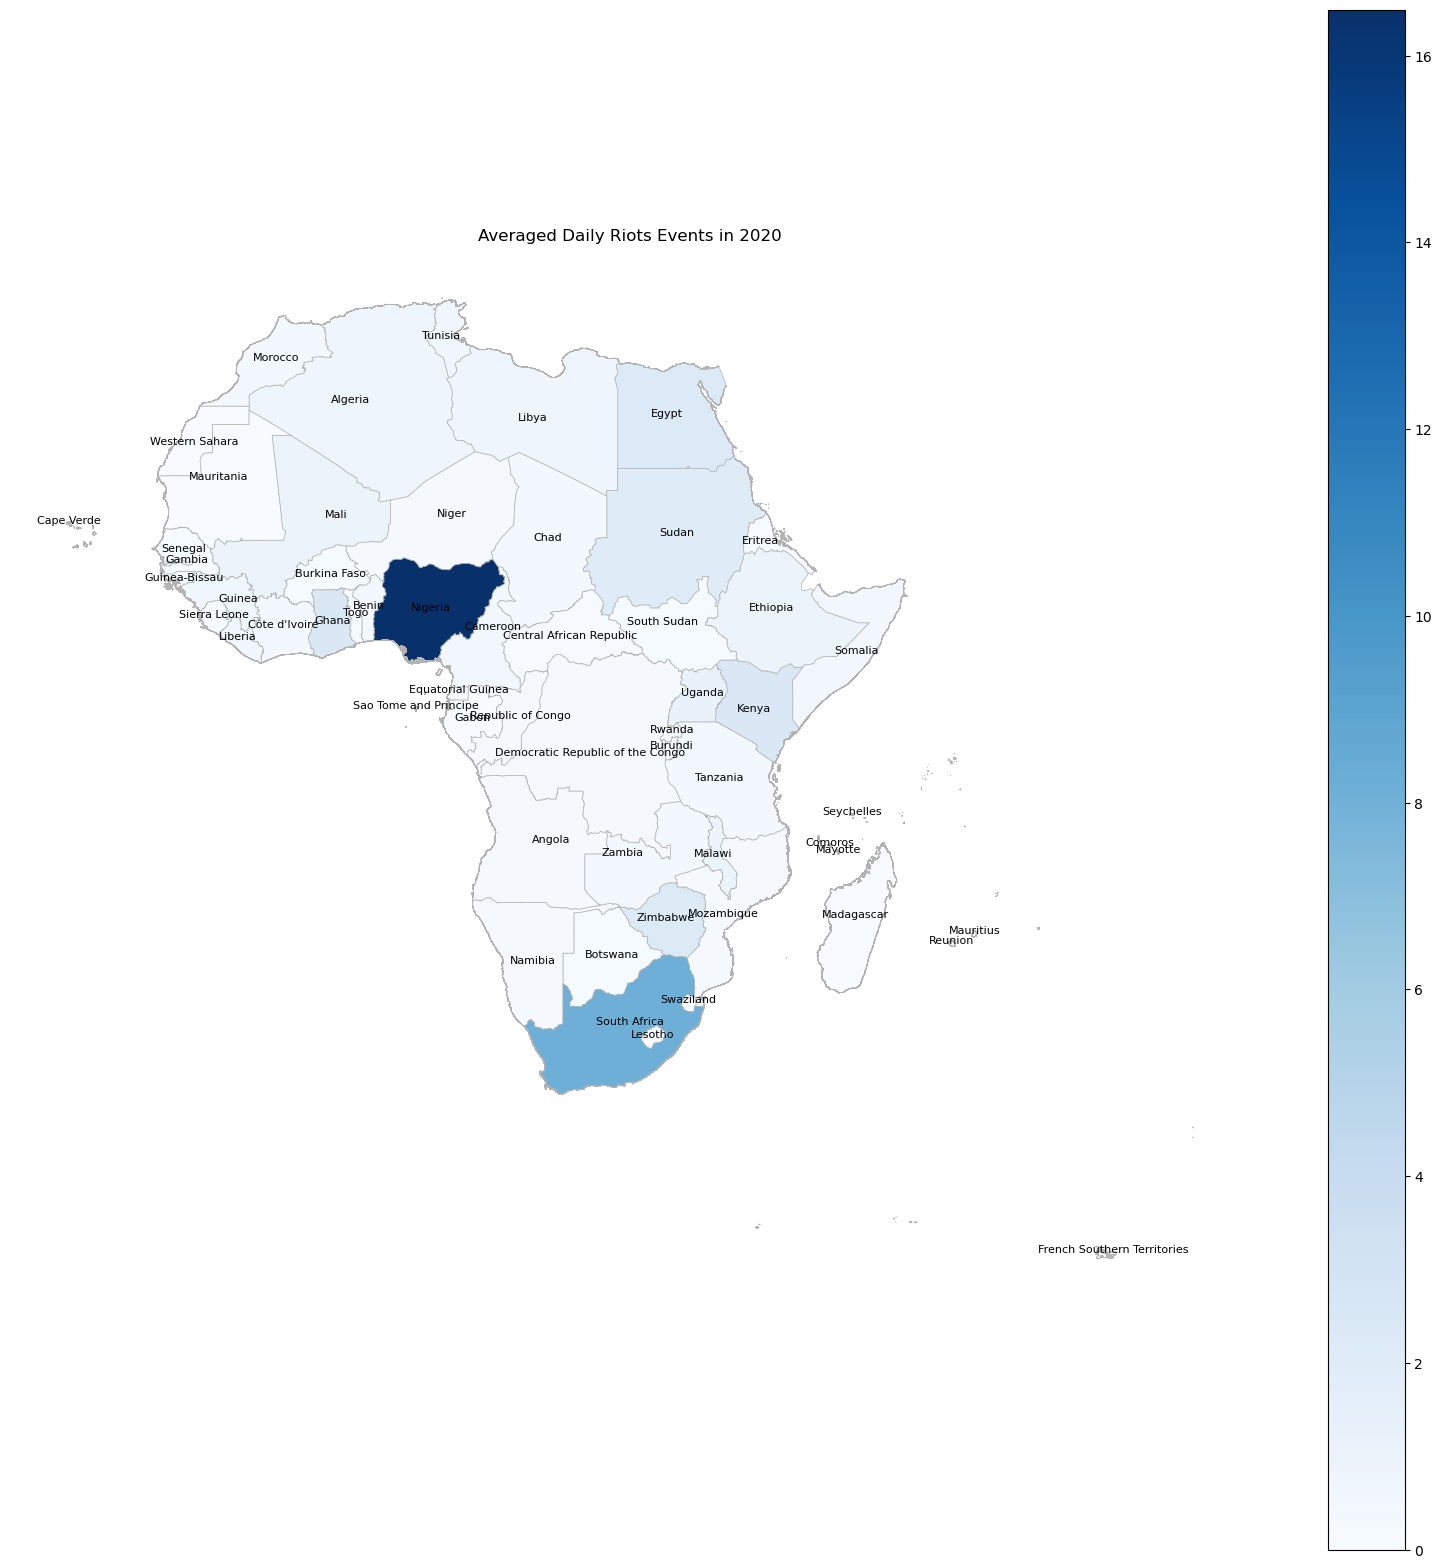

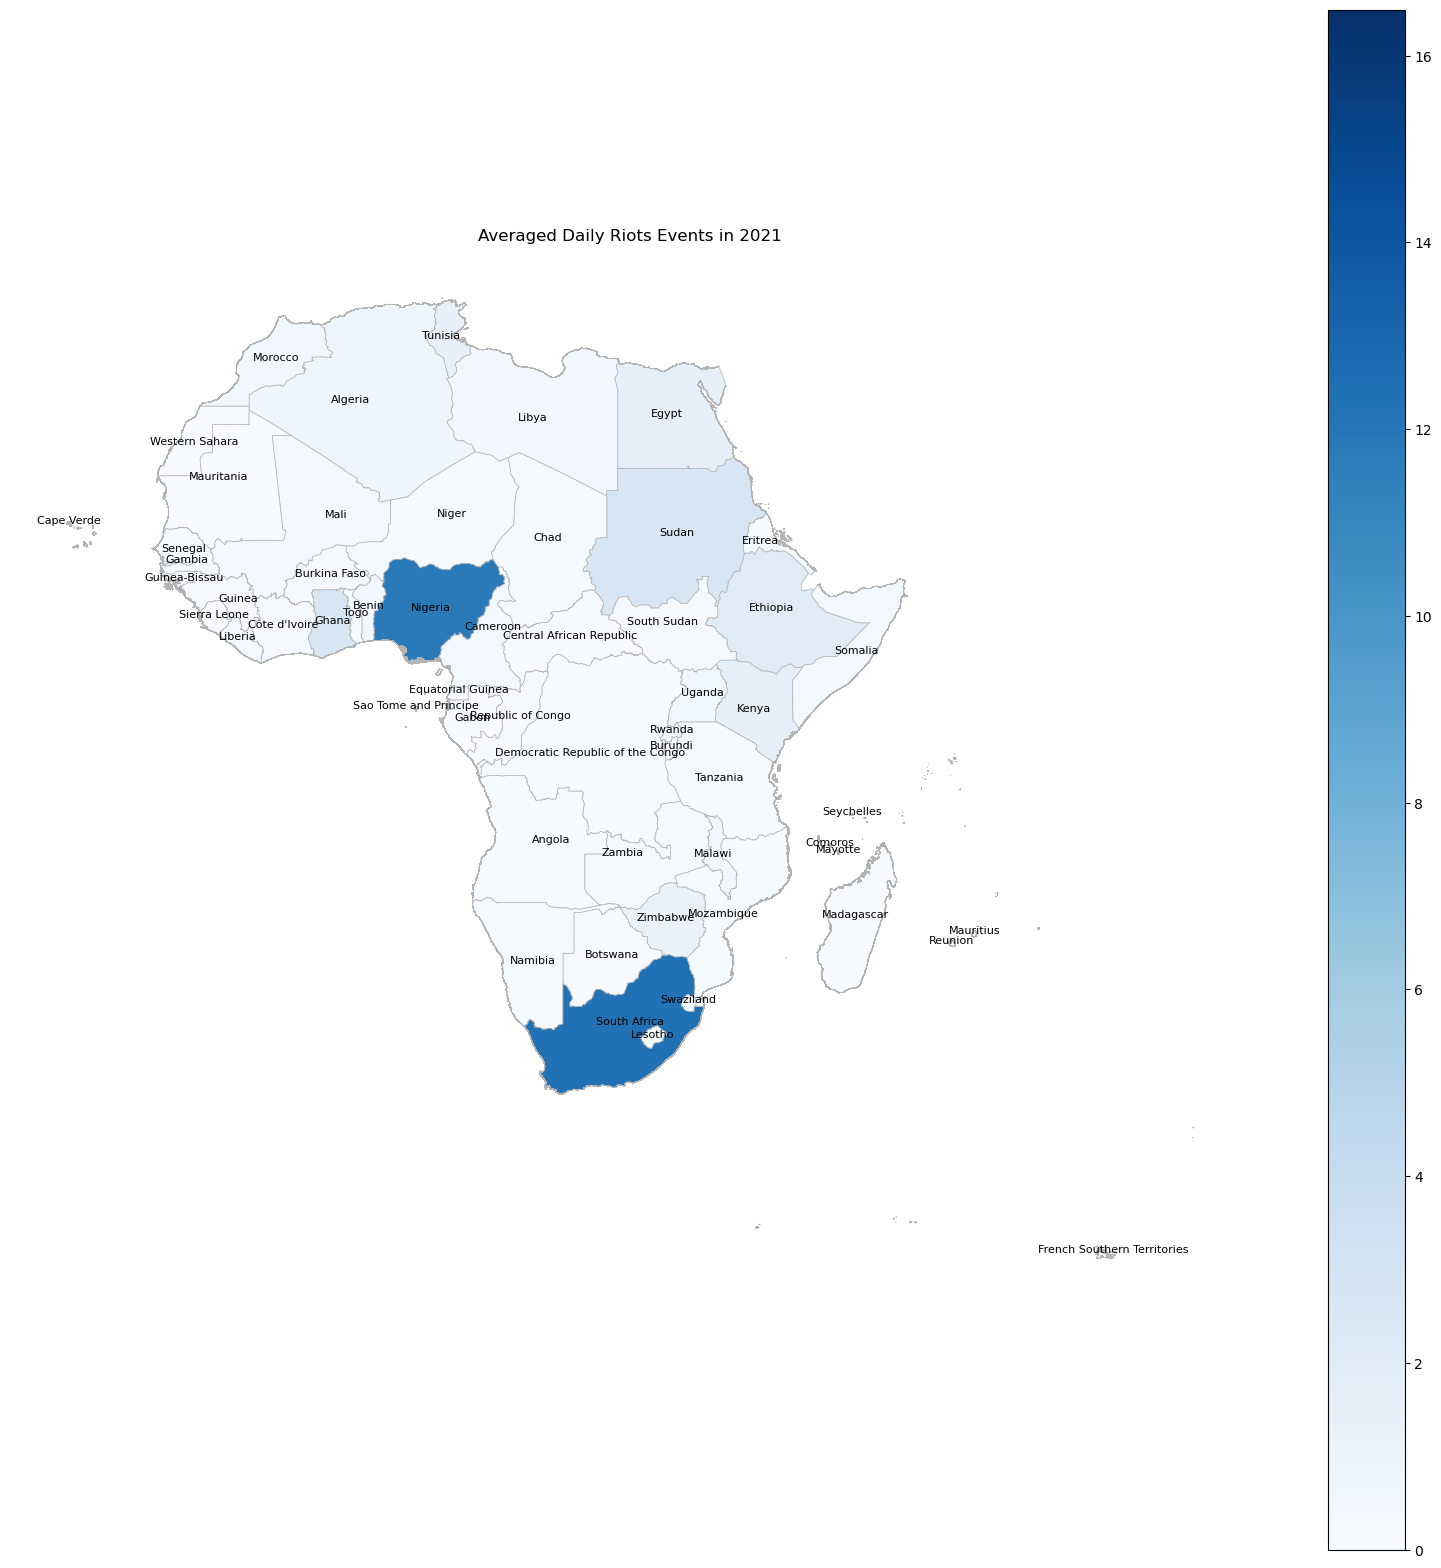

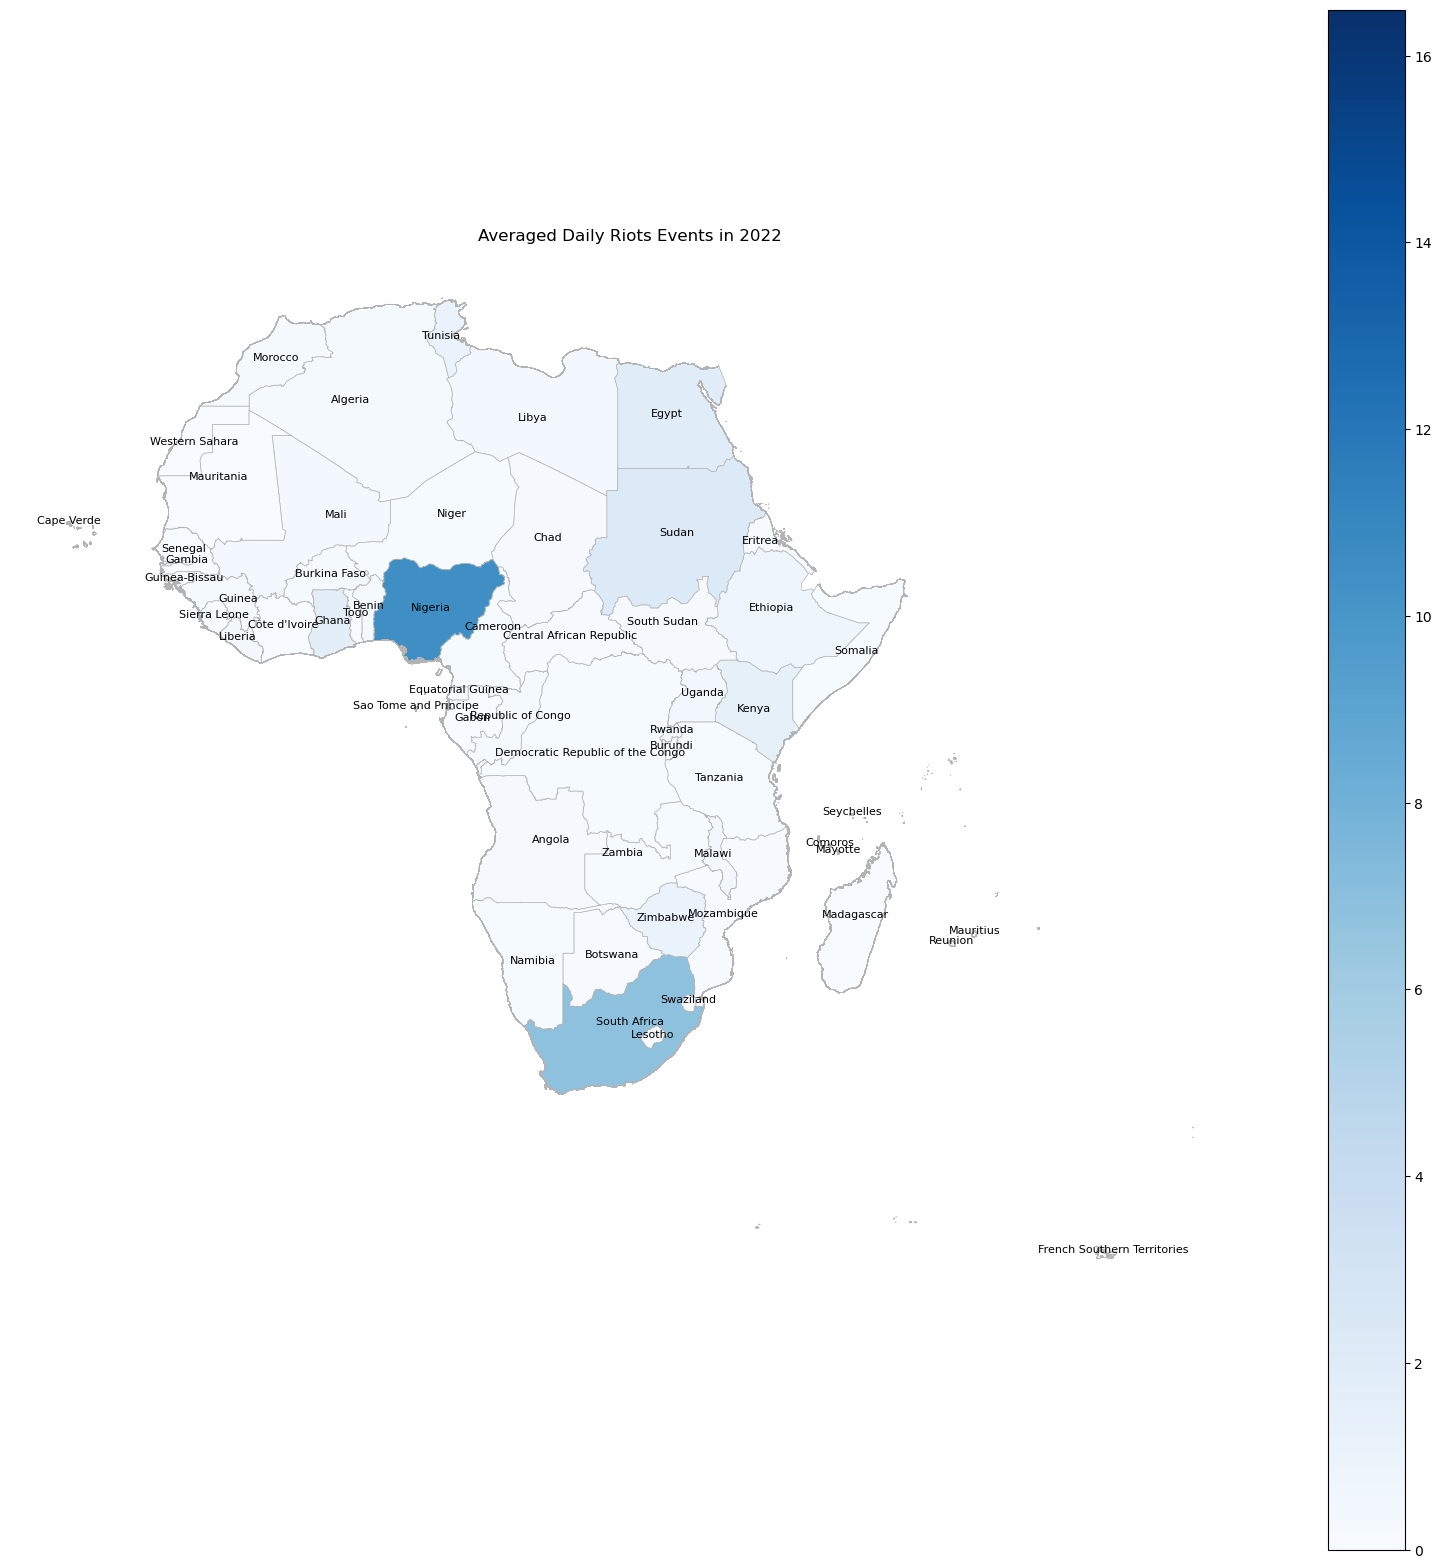

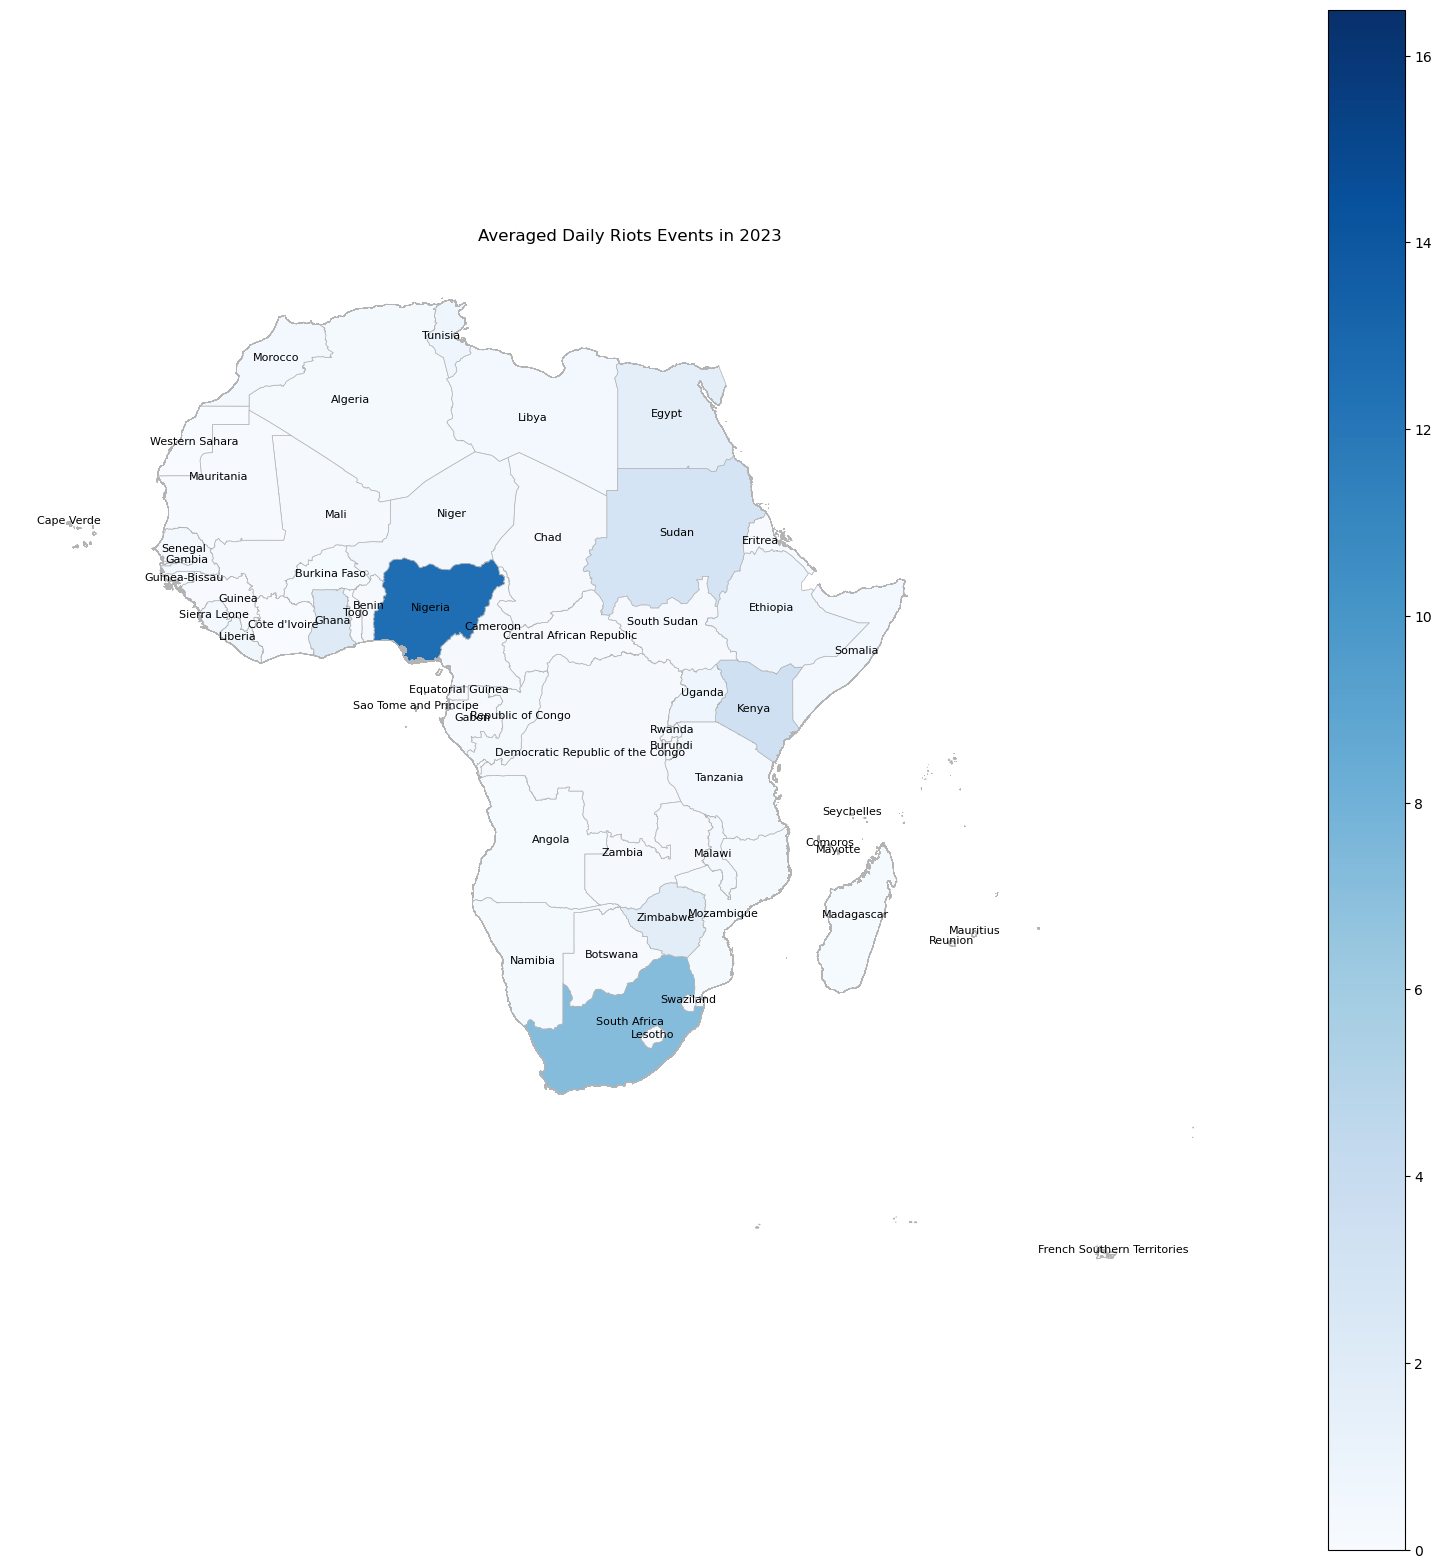

In [19]:
# This time trying to plot according to a normalized colorbar

from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=gbmean["count"].min(),
                    vcenter=(gbmean["count"].max()-gbmean["count"].min())/2,
                    vmax=gbmean["count"].max())

for year in ["2020","2021","2022","2023"]:
    print(f"Saving image for {year} ...")
    fig, ax = plt.subplots(1, figsize=(20,20))
    merged = pd.merge(geometries, gbmean[gbmean.Year==year], how="left", on="NAME_0").rename(columns={"count":"value"})
    #merged.value = merged.value/gbmean["count"].max()
    
    merged.plot(column='value', cmap='Blues', linewidth=0.5, norm = norm, ax=ax, edgecolor='0.7',legend = True);
    merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        plt.annotate(row['NAME_0'], xy=row['coords'], horizontalalignment='center', fontsize=8)
    
    ax.axis('off')
    ax.set_title(f"Averaged Daily Riots Events in {year}")
    plt.savefig(f"./pics/avg_riots_{year}.png")

# Unconventional mass violence: CAMEO `EventRootCode=20`

In [37]:
timeseries = pd.read_parquet("./data/timeseries_cameo20.parquet")
timeseries["Year"]  = timeseries.Date.apply(lambda x: str(x)[0:4])
timeseries["Month"] = timeseries.Date.apply(lambda x: str(x)[4:6])
timeseries["Day"]   = timeseries.Date.apply(lambda x: str(x)[6:8])
timeseries["Date"]  = timeseries.Date.transform(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

In [38]:
# extracting those countries that present the highest amount of events in the whole period
gb = timeseries.groupby(["NAME_0"])["count"].sum()
war = pd.DataFrame({"count": gb}).sort_values(by="count", ascending=False)

## Timeseries plotting.

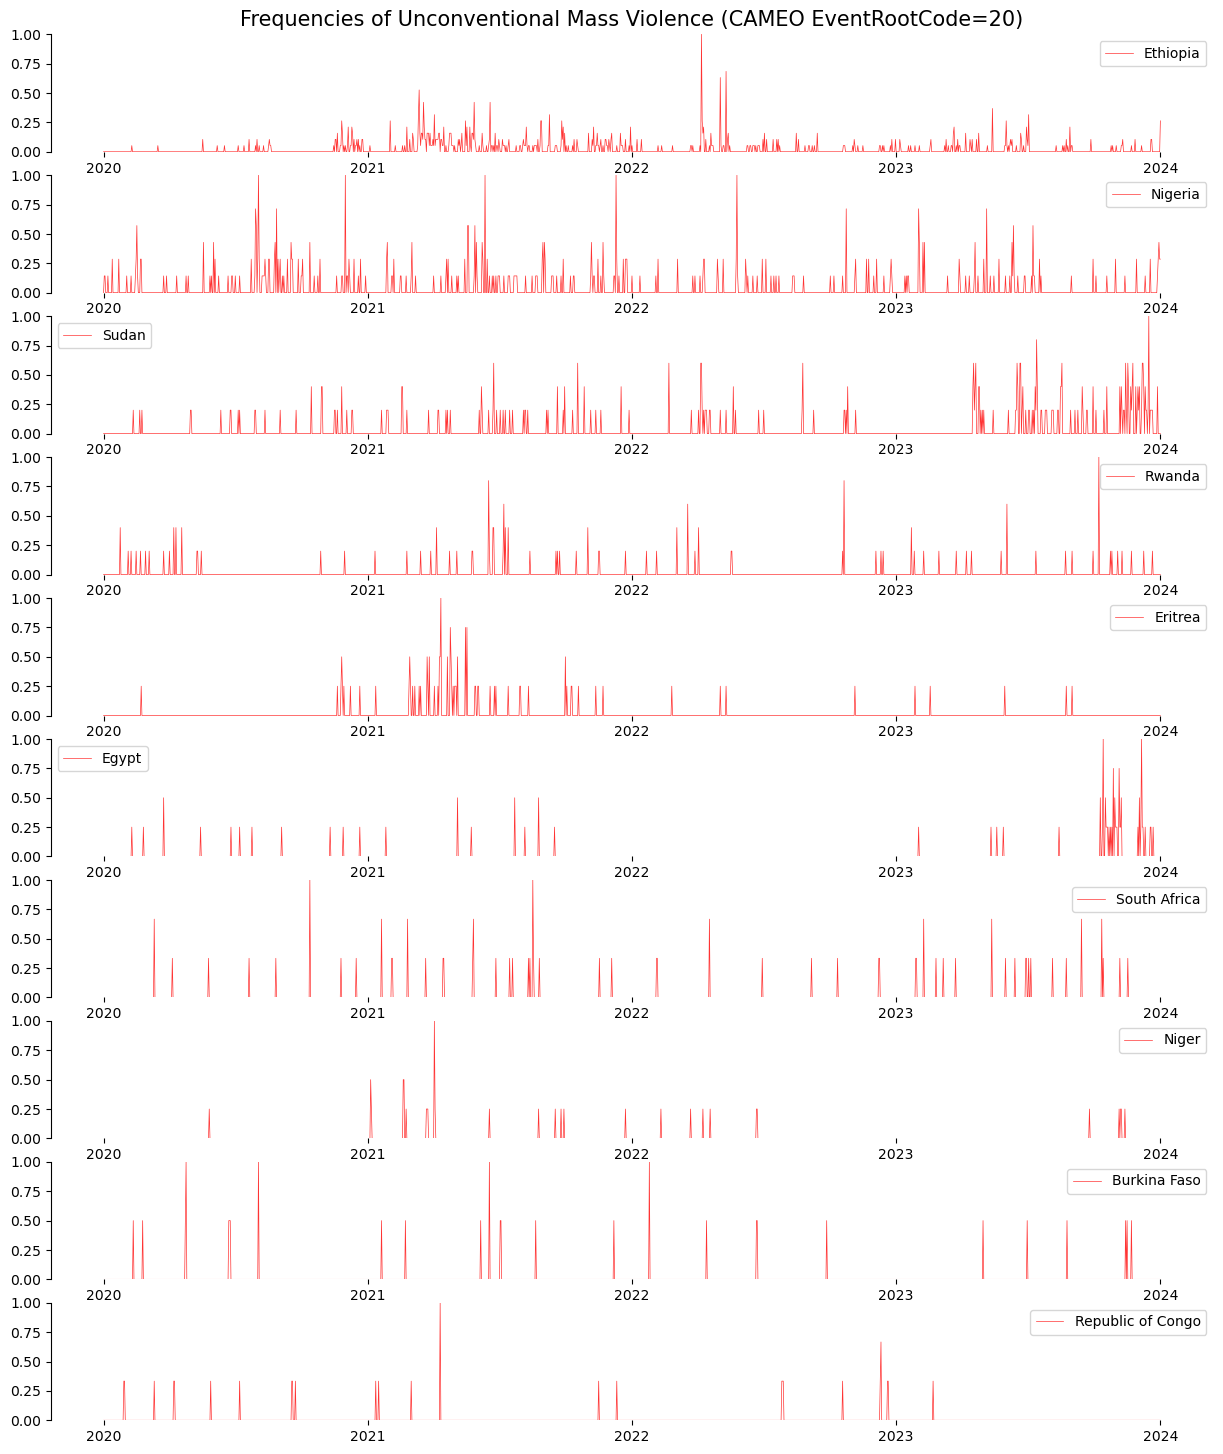

In [39]:
import matplotlib as mpl

mpl.rcParams['axes.spines.left']   = True
mpl.rcParams['axes.spines.right']  = False
mpl.rcParams['axes.spines.top']    = False
mpl.rcParams['axes.spines.bottom'] = False

country_names = war[0:10].index 

fig = plt.figure(figsize=(15,18))

for i,country in enumerate(country_names):
    ax = plt.subplot(10,1,i+1)
    series = timeseries[timeseries.NAME_0 == country]["count"]
    ax.plot(series/series.max(), linewidth=0.5, alpha = 0.8, label = country, color = "red")
    ax.set_ylim((0.,1.))
    ax.set_xticks((range(0, series.shape[0], series.shape[0]//4)),labels = ["2020", "2021", "2022", "2023", "2024"])
    ax.legend()
    if i==0:
        ax.set_title("Frequencies of Unconventional Mass Violence (CAMEO EventRootCode=20)", fontsize=15)
plt.savefig("./pics/massviolence_frequencies.png")

## Choropleth map visualization.

Saving image for 2020 ...
Saving image for 2021 ...
Saving image for 2022 ...
Saving image for 2023 ...


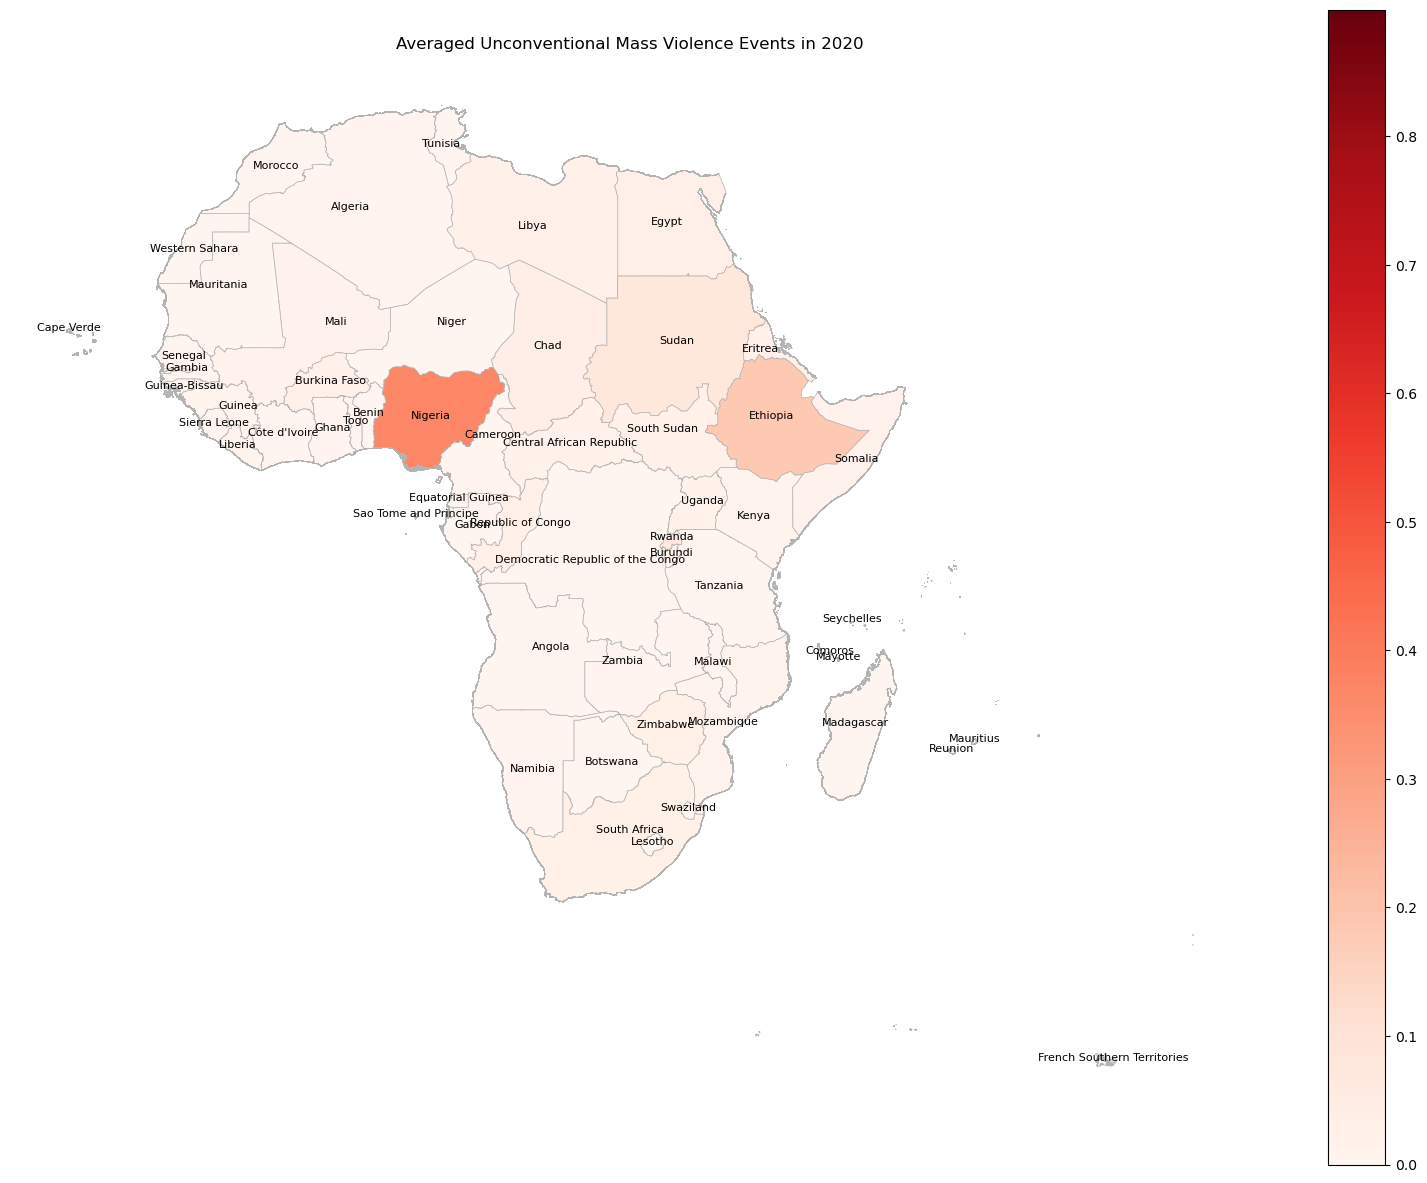

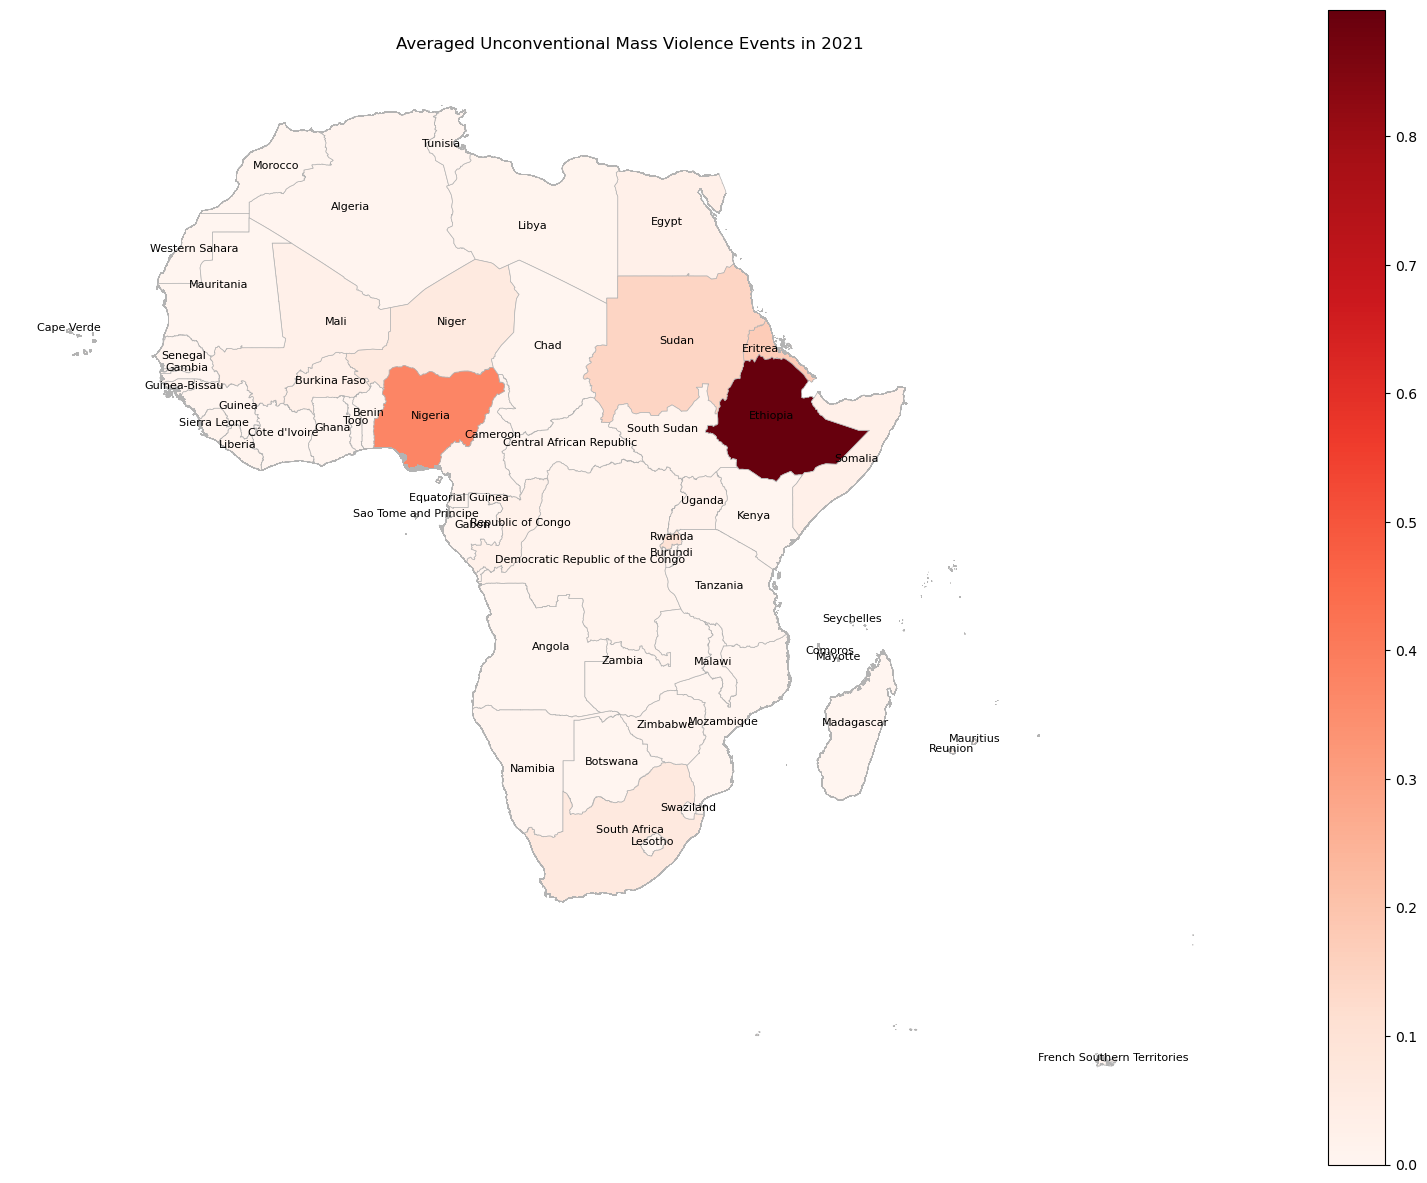

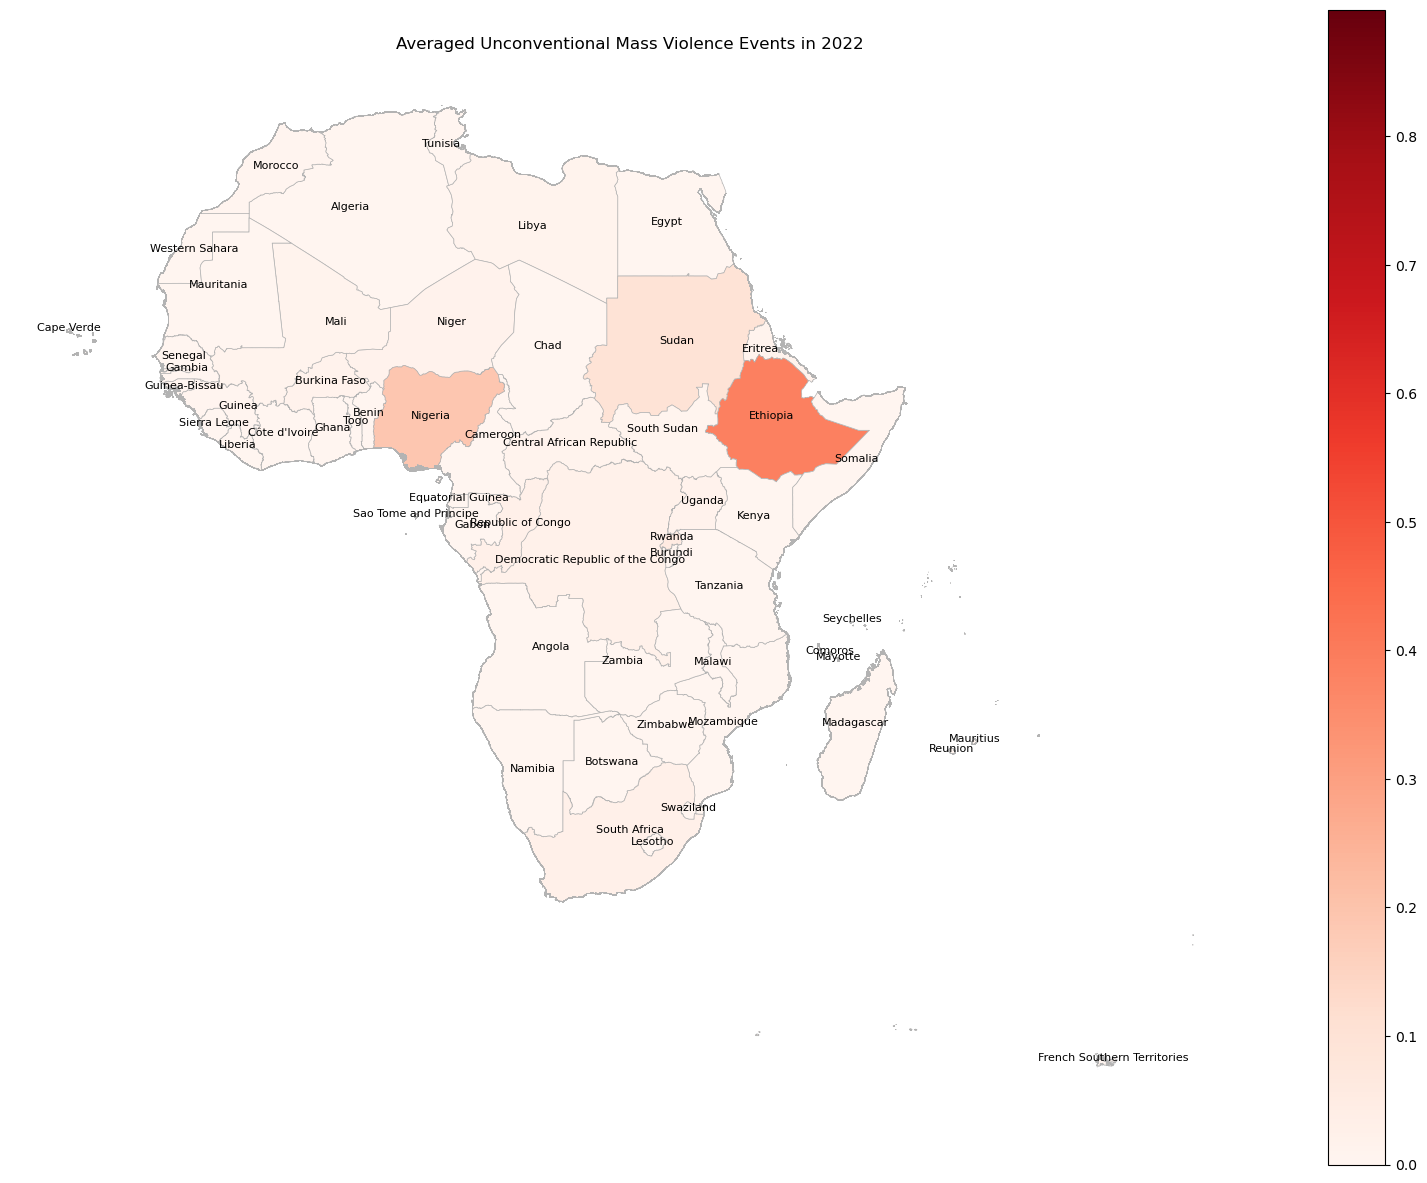

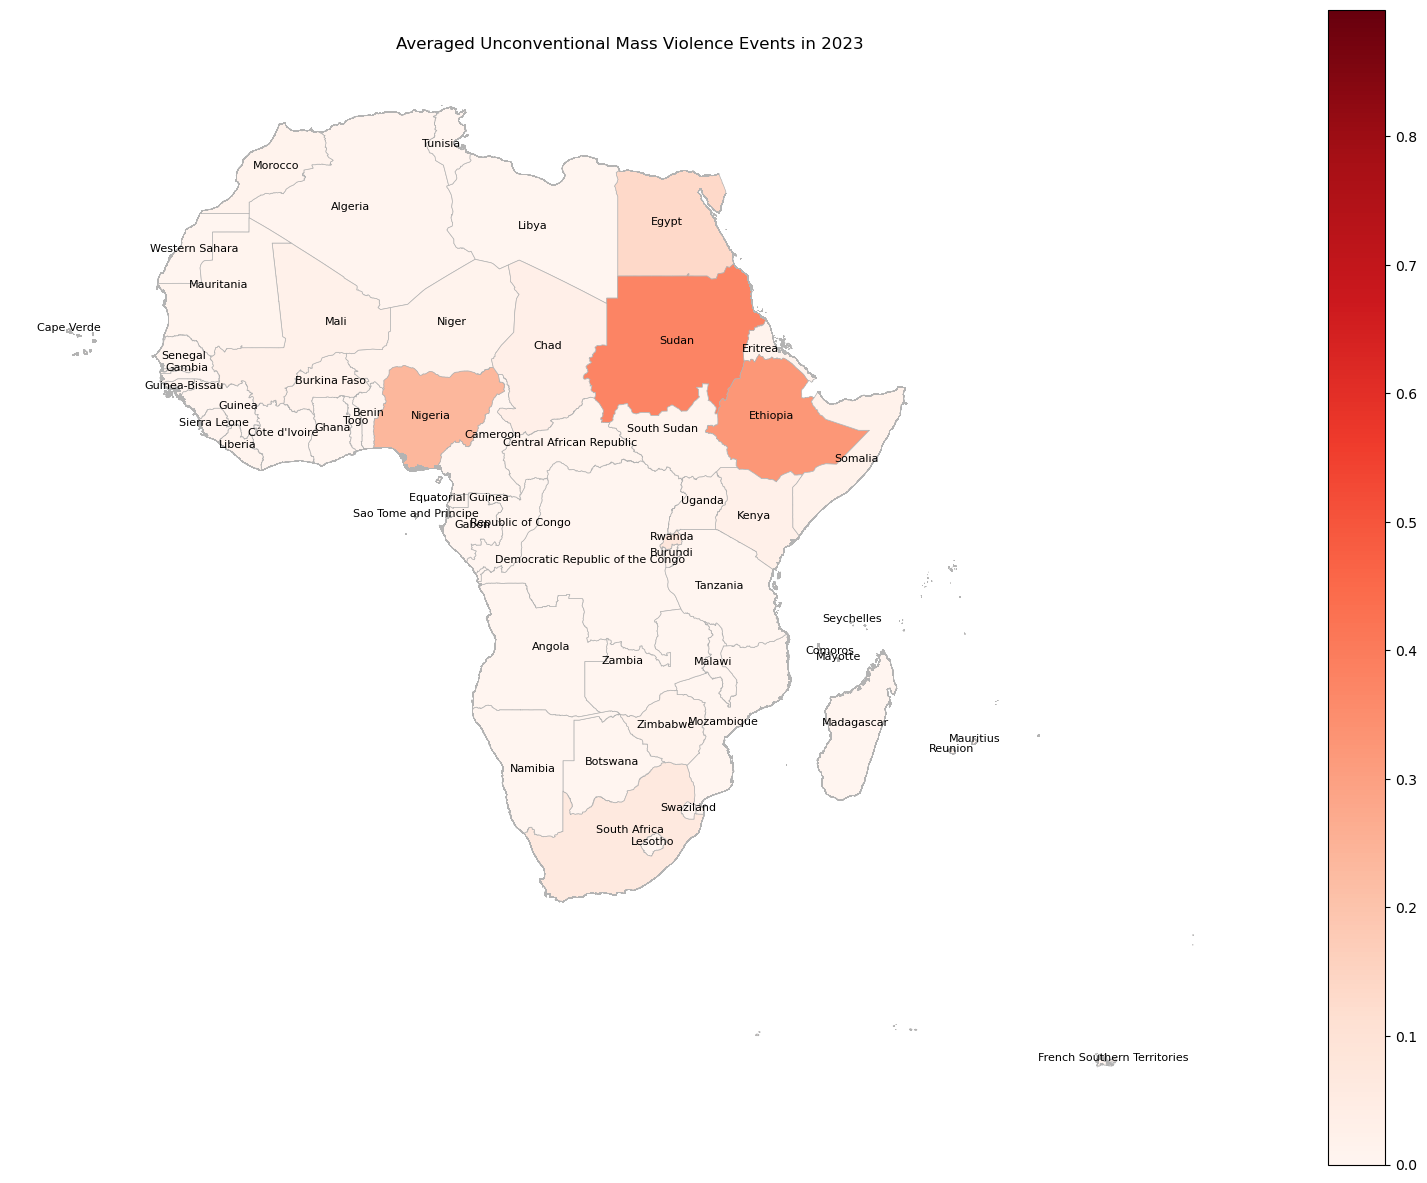

In [40]:
geometries = gpd.read_file("./Africa_Boundaries-shp/")
gbmean = timeseries.groupby(["NAME_0", "Year"])["count"].mean().to_frame().reset_index()

from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=gbmean["count"].min(),
                    vcenter=(gbmean["count"].max()-gbmean["count"].min())/2,
                    vmax=gbmean["count"].max())

for year in ["2020","2021","2022","2023"]:
    print(f"Saving image for {year} ...")
    fig, ax = plt.subplots(1, figsize=(20,15))
    merged = pd.merge(geometries, gbmean[gbmean.Year==year], how="left", on="NAME_0").rename(columns={"count":"value"})
    #merged.value = merged.value/gbmean["count"].max()
    merged.plot(column='value', cmap='Reds', norm=norm, linewidth=0.5, ax=ax, edgecolor='0.7',legend = True);
    
    merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        plt.annotate(row['NAME_0'], xy=row['coords'], horizontalalignment='center', fontsize=8)
    
    ax.axis('off')
    ax.set_title(f"Averaged Unconventional Mass Violence Events in {year}")
    plt.savefig(f"./pics/avg_massviolence_{year}.png")

# Conventional violence: CAMEO `RootEventCode=19`



## Timeseries plotting.

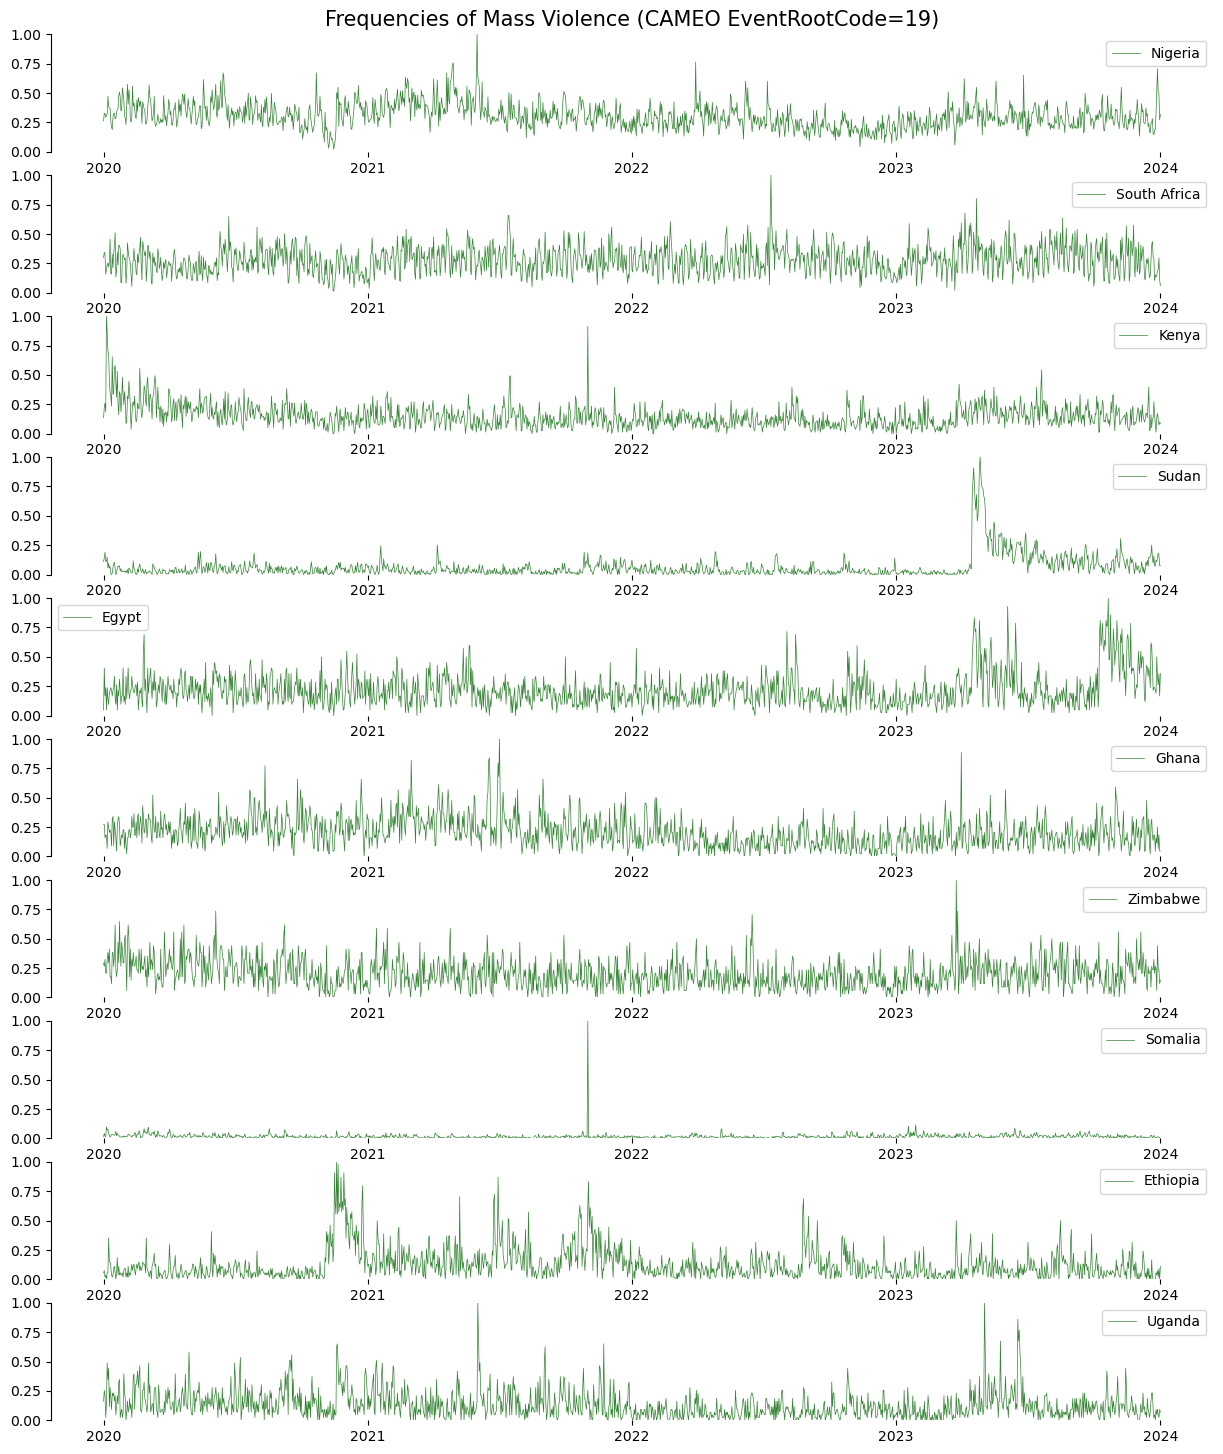

In [113]:
timeseries = pd.read_parquet("./data/timeseries_cameo19.parquet")
timeseries["Year"]  = timeseries.Date.apply(lambda x: str(x)[0:4])
timeseries["Month"] = timeseries.Date.apply(lambda x: str(x)[4:6])
timeseries["Day"]   = timeseries.Date.apply(lambda x: str(x)[6:8])
timeseries["Date"]  = timeseries.Date.transform(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

# extracting those countries that present the highest amount of events in the whole period
gb = timeseries.groupby(["NAME_0"])["count"].sum()
war = pd.DataFrame({"count": gb}).sort_values(by="count", ascending=False)

# timeseries plotting
import matplotlib as mpl

mpl.rcParams['axes.spines.left']   = True
mpl.rcParams['axes.spines.right']  = False
mpl.rcParams['axes.spines.top']    = False
mpl.rcParams['axes.spines.bottom'] = False

country_names = war[0:10].index 

fig = plt.figure(figsize=(15,18))

for i,country in enumerate(country_names):
    ax = plt.subplot(10,1,i+1)
    series = timeseries[timeseries.NAME_0 == country]["count"]
    ax.plot(series/series.max(), linewidth=0.5, alpha = 0.8, label = country, color = "darkgreen")
    ax.set_ylim((0.,1.))
    ax.set_xticks((range(0, series.shape[0], series.shape[0]//4)),labels = ["2020", "2021", "2022", "2023", "2024"])
    ax.legend()
    if i==0:
        ax.set_title("Frequencies of Mass Violence (CAMEO EventRootCode=19)", fontsize=15)
plt.savefig("./pics/violence_frequencies.png")

In [114]:
gbmean = timeseries.groupby(["NAME_0", "Year"])["count"].mean().to_frame().reset_index()

gbmean

NAME_0  Year     count
0     Algeria  2020  1.469945
1     Algeria  2021  1.495890
2     Algeria  2022  1.232877
3     Algeria  2023  1.509589
4      Angola  2020  0.915301
..        ...   ...       ...
223    Zambia  2023  1.164384
224  Zimbabwe  2020  8.428962
225  Zimbabwe  2021  6.553425
226  Zimbabwe  2022  5.482192
227  Zimbabwe  2023  7.189041

[228 rows x 3 columns]

## Choropleth map visualization.

Saving image for 2020 ...
Saving image for 2021 ...
Saving image for 2022 ...
Saving image for 2023 ...


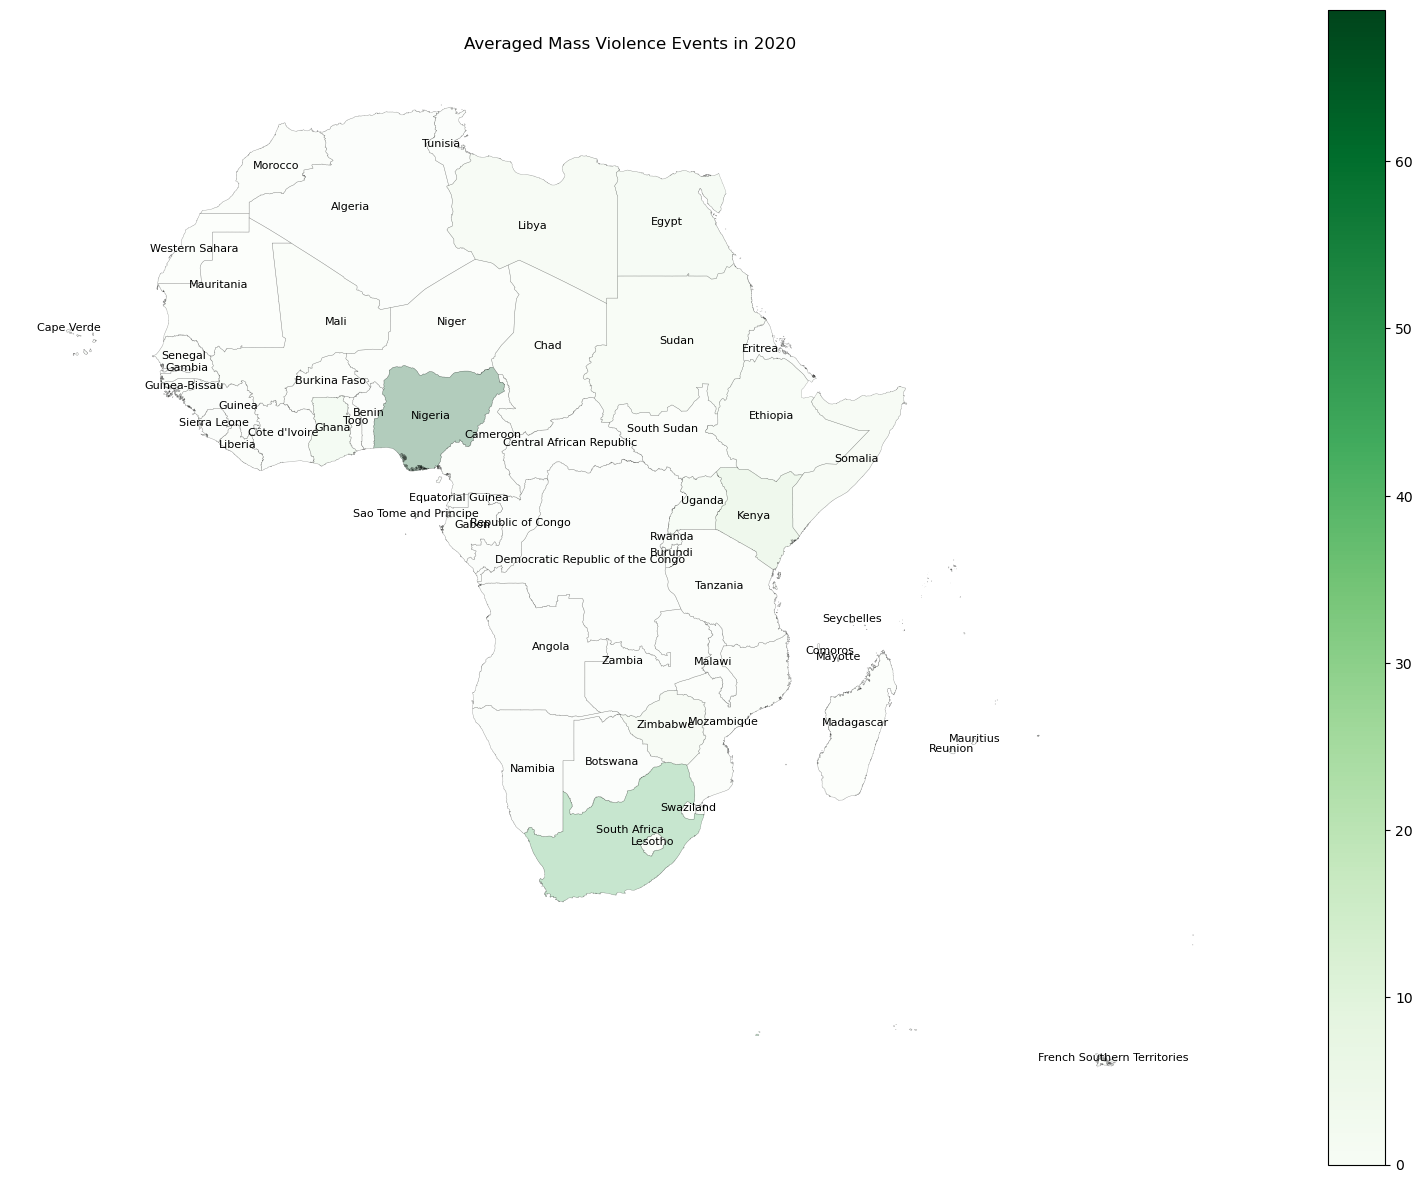

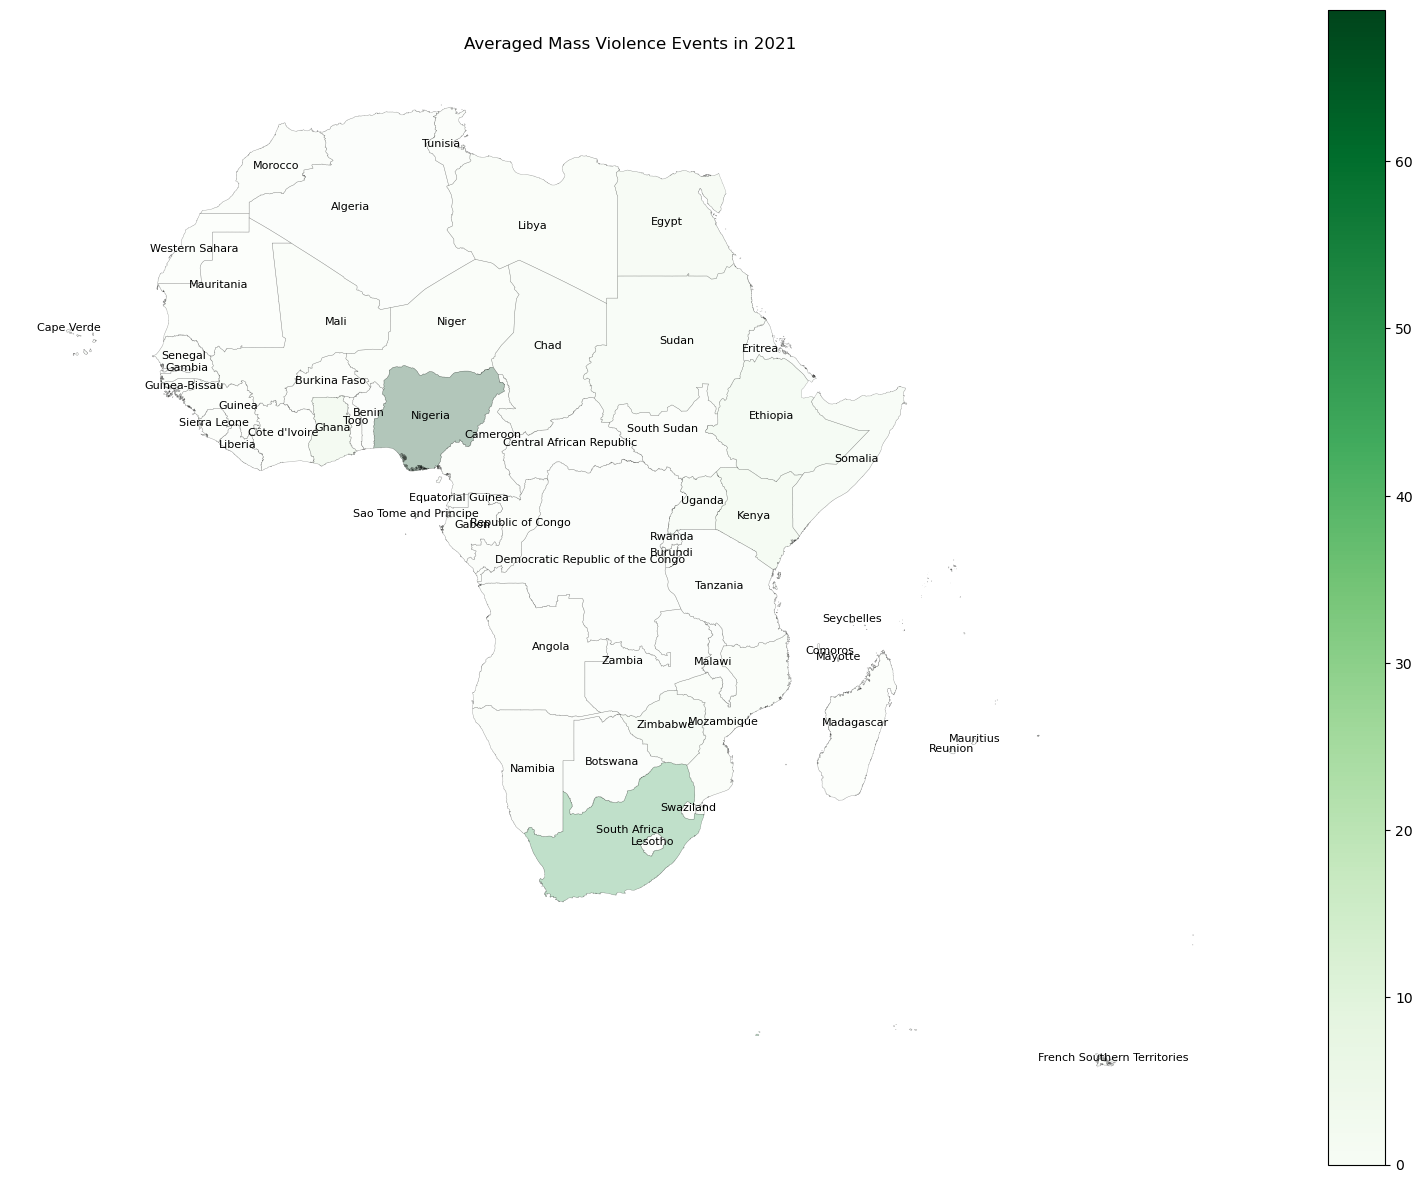

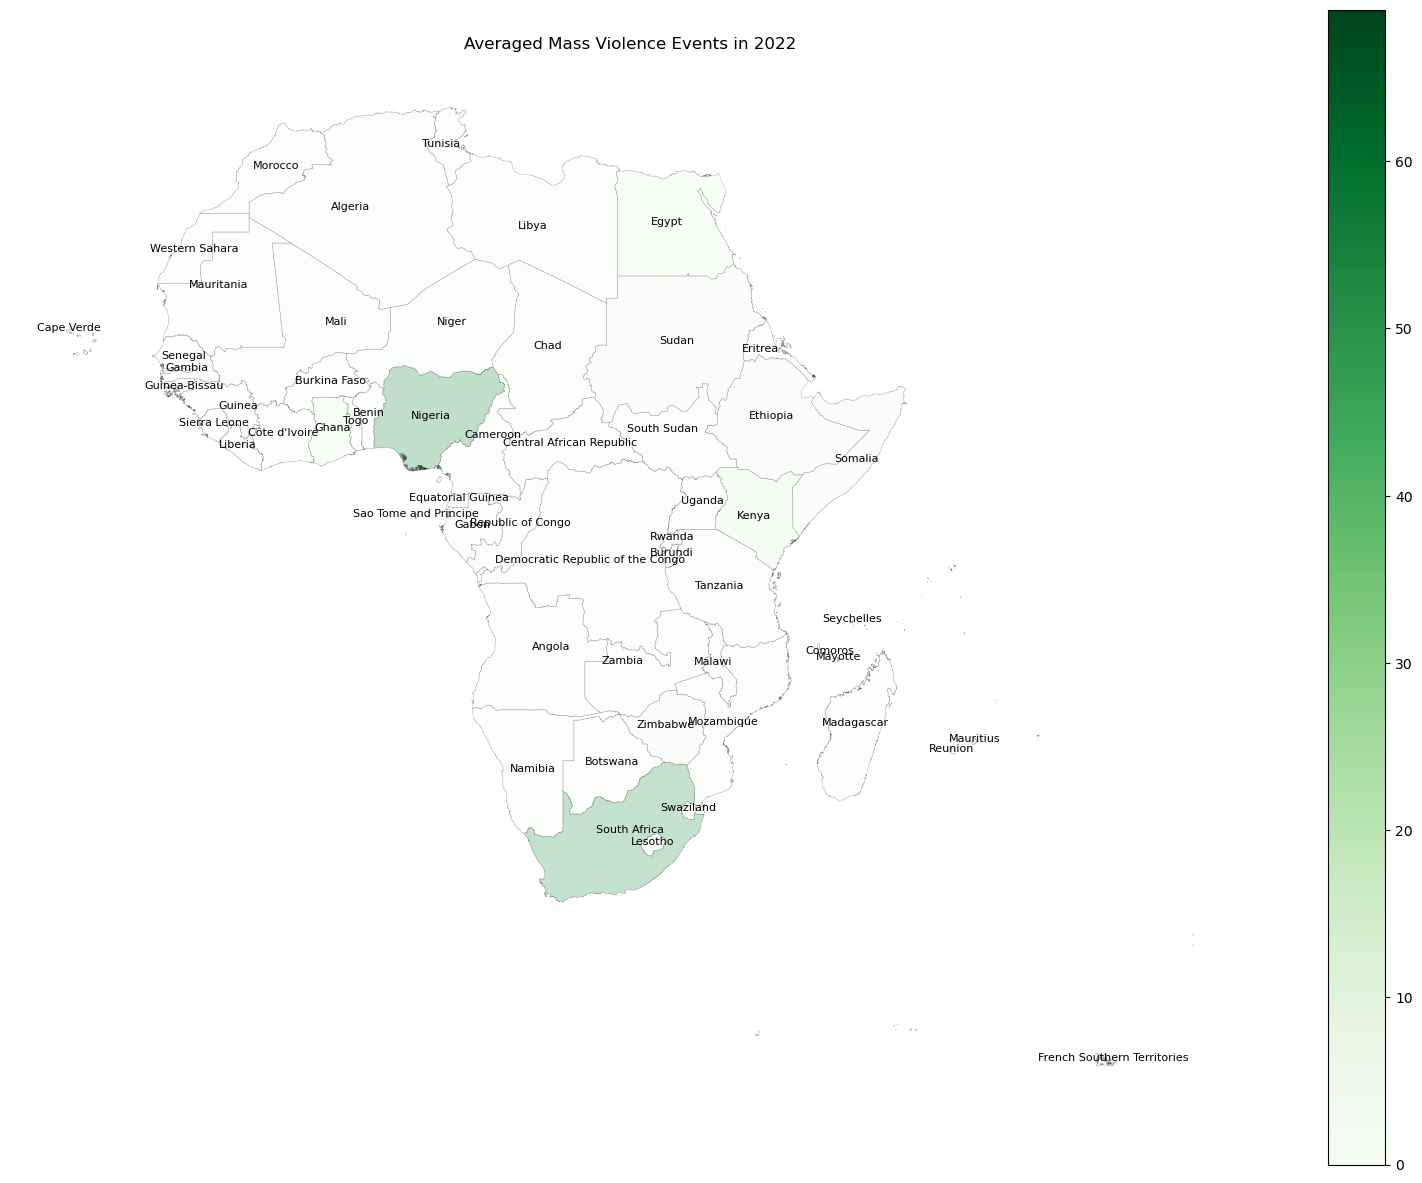

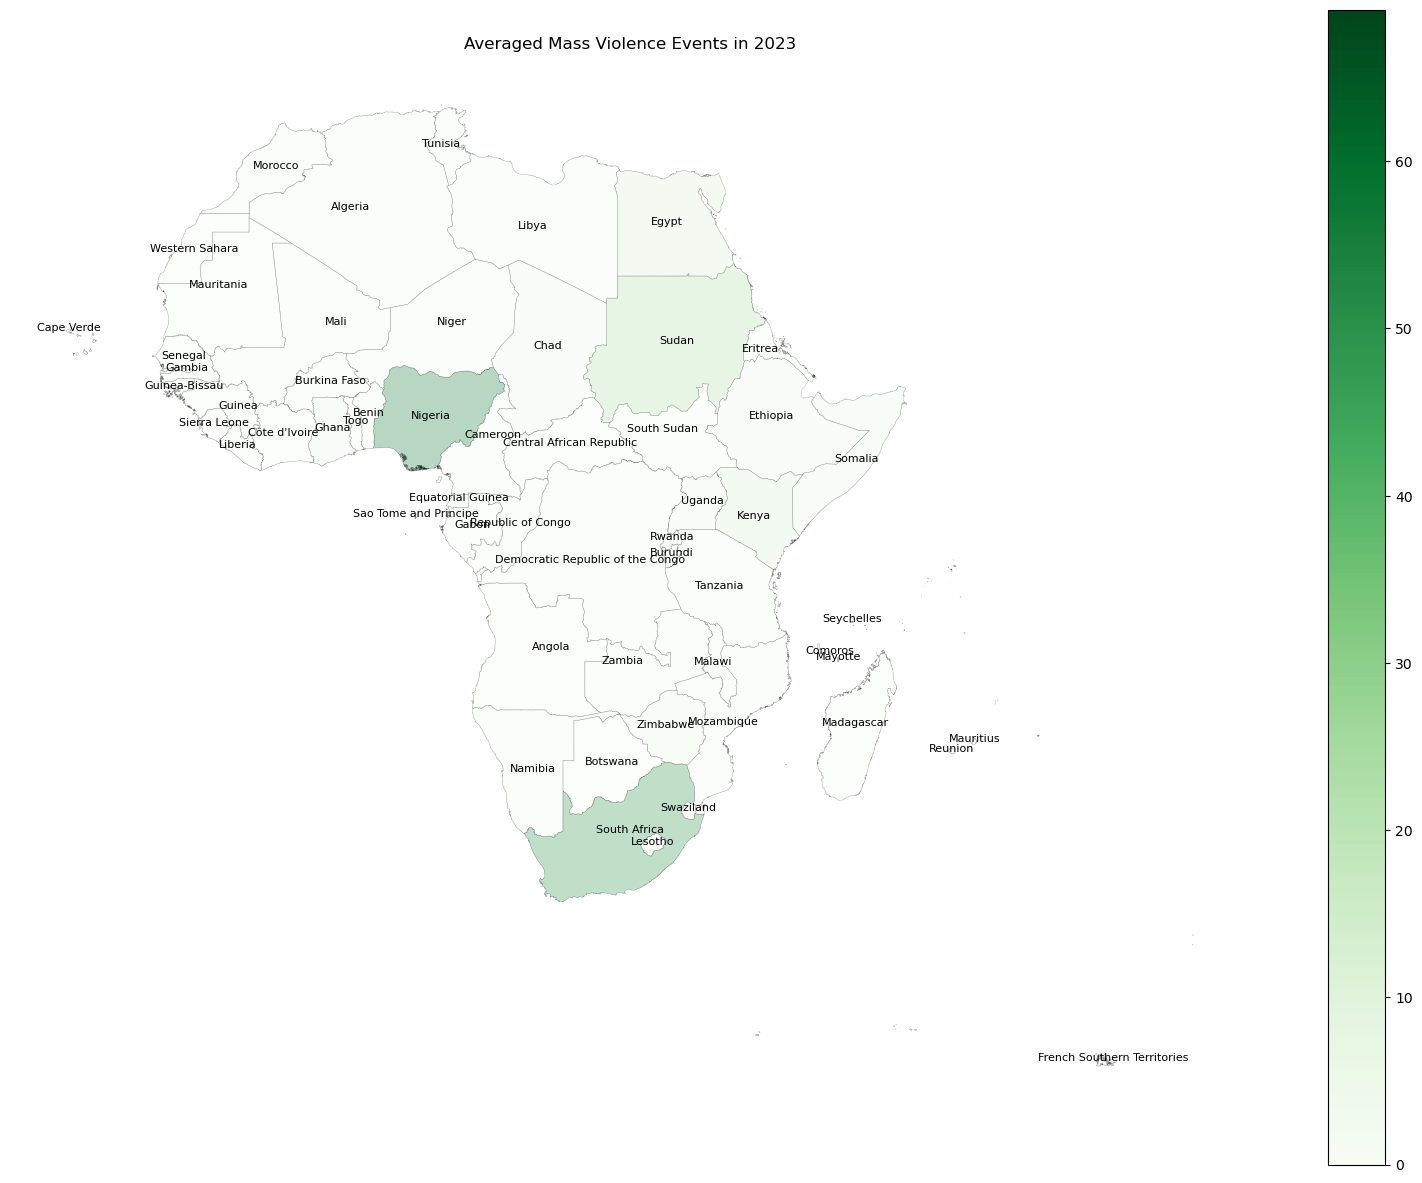

In [117]:
geometries = gpd.read_file("./Africa_Boundaries-shp/")
gbmean = timeseries.groupby(["NAME_0", "Year"])["count"].mean().to_frame().reset_index()

from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=gbmean["count"].min(),
                    vcenter=(gbmean["count"].max()-gbmean["count"].min())/2,
                    vmax=gbmean["count"].max())


for year in ["2020","2021","2022","2023"]:
    print(f"Saving image for {year} ...")
    fig, ax = plt.subplots(1, figsize=(20,15))
    merged = pd.merge(geometries, gbmean[gbmean.Year==year], how="left", on="NAME_0").rename(columns={"count":"value"})
    #merged.value = merged.value/gbmean["count"].max()
    merged.plot(column='value', cmap='Greens', norm=norm, linewidth=0.3, edgecolor="black", alpha=0.3, ax=ax, legend = True);
    
    merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        plt.annotate(row['NAME_0'], xy=row['coords'], horizontalalignment='center', fontsize=8)
    
    ax.axis('off')
    ax.set_title(f"Averaged Mass Violence Events in {year}")
    plt.savefig(f"./pics/avg_violence_{year}.png")

Alternative choroplet map visualization.

Saving image for 2020 ...
Saving image for 2021 ...
Saving image for 2022 ...


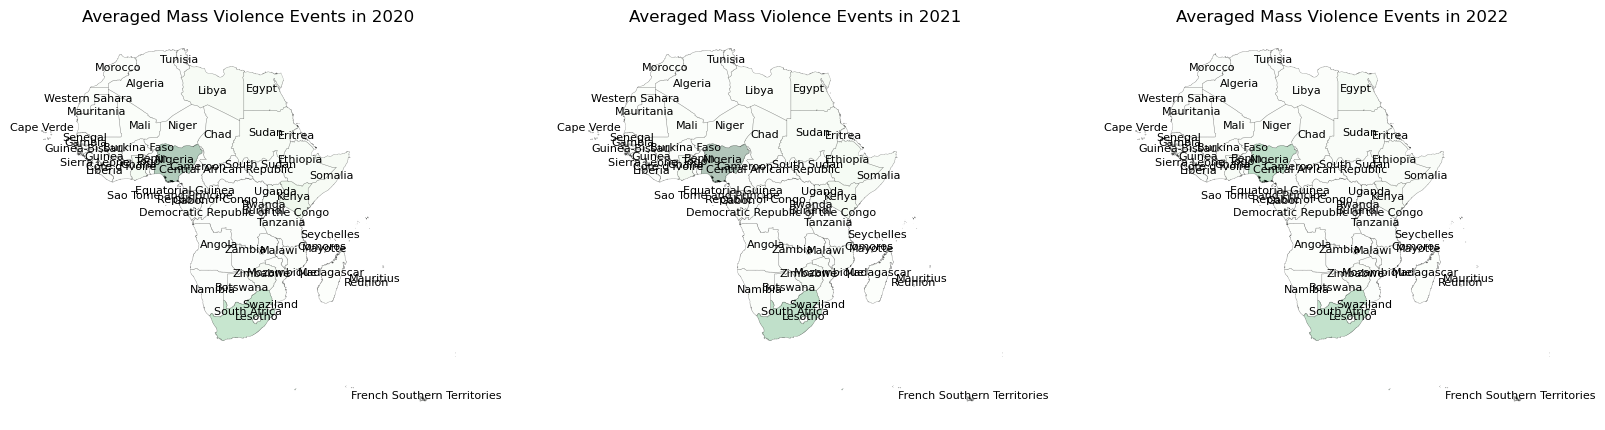

In [184]:
from matplotlib.colors import TwoSlopeNorm
geometries = gpd.read_file("./Africa_Boundaries-shp/")
gbmean = timeseries.groupby(["NAME_0", "Year"])["count"].mean().to_frame().reset_index()

norm = TwoSlopeNorm(vmin=gbmean["count"].min(),
                    vcenter=(gbmean["count"].max()-gbmean["count"].min())/2,
                    vmax=gbmean["count"].max())

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
for i,year in enumerate(["2020","2021","2022"]):
    print(f"Saving image for {year} ...")
    ax = axs[i]
    merged = pd.merge(geometries, gbmean[gbmean.Year==year], how="left", on="NAME_0").rename(columns={"count":"value"})
    merged.plot(column='value', cmap='Greens', norm=norm, linewidth=0.3, edgecolor="black", alpha=0.3, ax=ax, legend = False);
    
    merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        ax.annotate(row['NAME_0'], xy=row['coords'], horizontalalignment='center', fontsize=8)
    
    ax.axis('off')
    ax.set_title(f"Averaged Mass Violence Events in {year}")

# Preparing the final dataset

## Loading event count predictors.

In [5]:
dfs = []
for i,cameo in enumerate([5,6,7,10,12,13,14,19,20]):
    df = pd.read_parquet(f"./data/timeseries_cameo{cameo}.parquet")
    df["Year"] = df.Date.apply(lambda x: str(x)[0:4])
    df["Month"] = df.Date.apply(lambda x: str(x)[4:6])
    #df = df[df.Year.isin(["2020", "2021", "2022"])]
    gb = df.groupby(["NAME_0", "Year"])["count"].sum().to_frame().reset_index().rename(columns={"count":f'EventRoot{cameo}'})
    dfs.append(gb)
    if i == 0:
        final = dfs[0]
    else:
        final = final.merge(dfs[i], on=["NAME_0","Year"])

In [6]:
final

NAME_0  Year  EventRoot5  EventRoot6  EventRoot7  EventRoot10  \
0     Algeria  2020         736         288         319          161   
1     Algeria  2021         767         224         266          162   
2     Algeria  2022         707         229         225          109   
3     Algeria  2023         796         290         435           92   
4      Angola  2020         790         301         405           98   
..        ...   ...         ...         ...         ...          ...   
223    Zambia  2023        1476         294         731          189   
224  Zimbabwe  2020        4604        1958        3017         1320   
225  Zimbabwe  2021        4043        1410        2481          848   
226  Zimbabwe  2022        4072        1348        2161          820   
227  Zimbabwe  2023        5540        1787        2863         1141   

     EventRoot12  EventRoot13  EventRoot14  EventRoot19  EventRoot20  
0            300          158          300          538            2  
1            276          112          303          546            2  
2            229           80           95          450            1  
3            186          102          102          551            2  
4            225          108           83          335            1  
..           ...          ...          ...          ...          ...  
223          339          192           84          425            0  
224         2283         1106          806         3085           11  
225         1475          737          437         2392            2  
226         1237          623          377         2001            0  
227         1834          809          635         2624            5  

[228 rows x 11 columns]

Compute the binary predictors

In [7]:
final["CurrentYear"] = final.EventRoot20.apply(lambda x: 1. if x>0 else 0.)

#predictor = np.zeros((final.shape[0]))
#for i,line in final.iterrows():
#    if line.Year == "2023":
#        predictor[i] = np.nan
#        continue
#    predictor[i] = 1. if final.iloc[(int(i)+1)].EventRoot20>0 else 0.
#final["NextYear"] = predictor
#final = final[~final.NextYear.isna()]

final["ISO"] = final.NAME_0.apply(lambda x: geometries[geometries.NAME_0==x].ISO.unique()[0])
final.sort_values("ISO", inplace=True)
final

NAME_0  Year  EventRoot5  EventRoot6  EventRoot7  \
4                         Angola  2020         790         301         405   
5                         Angola  2021         583         161         259   
6                         Angola  2022         537         183         193   
7                         Angola  2023         704         222         276   
68   French Southern Territories  2020           0           0           0   
..                           ...   ...         ...         ...         ...   
223                       Zambia  2023        1476         294         731   
226                     Zimbabwe  2022        4072        1348        2161   
224                     Zimbabwe  2020        4604        1958        3017   
225                     Zimbabwe  2021        4043        1410        2481   
227                     Zimbabwe  2023        5540        1787        2863   

     EventRoot10  EventRoot12  EventRoot13  EventRoot14  EventRoot19  \
4             98          225          108           83          335   
5             57          130           63           54          231   
6             43          183           39           78          250   
7             62          151           54           60          284   
68             0            0            0            0            0   
..           ...          ...          ...          ...          ...   
223          189          339          192           84          425   
226          820         1237          623          377         2001   
224         1320         2283         1106          806         3085   
225          848         1475          737          437         2392   
227         1141         1834          809          635         2624   

     EventRoot20  CurrentYear  ISO  
4              1          1.0  AGO  
5              1          1.0  AGO  
6              0          0.0  AGO  
7              1          1.0  AGO  
68             0          0.0  ATF  
..           ...          ...  ...  
223            0          0.0  ZMB  
226            0          0.0  ZWE  
224           11          1.0  ZWE  
225            2          1.0  ZWE  
227            5          1.0  ZWE  

[228 rows x 13 columns]

## Load Neighbours related predictors.

In [8]:
# loading neighbours
namelist = []
for item in sorted(os.listdir("./data")):
    if item.startswith("neighbours"):
        name = item.split("_")[1]
        if not name in namelist and name not in ("avg","laginfo", "2022", "2023"):
            namelist.append(name)
            
neigh = pd.concat([pd.read_parquet(f"./data/neighbours_{name}_2020_2021_2022_2023.parquet") for name in namelist])
neigh = neigh.groupby(["ISO", "Year"])[["AvgTone", "GoldsteinScale"]].mean().reset_index().sort_values(by=["ISO", "Year"])
neigh["NAME_0"] = neigh.ISO.apply(lambda x: geometries[geometries.ISO==x].NAME_0.unique()[0])

In [9]:
# deprecated for joining dataframes
#for cname in namelist:
    #tmp1 = pd.read_parquet(f"./data/neighbours_{cname}_2020_2021_2022_avg.parquet")
    #tmp2 = pd.read_parquet(f"./data/neighbours_2023_{cname}_avg.parquet")
    #tmp  = pd.concat([tmp1,tmp2]).sort_values(by=["ISO", "Year", "Month", "Day"])
    #tmp.to_parquet(f"./data/neighbours_{cname}_2020_2021_2022_2023.parquet")
    #os.system(f"rm ./data/neighbours_2023_{cname}_avg.parquet")

In [10]:
final["cidx"] = final.NAME_0+final.Year
neigh["cidx"] = neigh.NAME_0+neigh.Year
commonidx = list(set(neigh.cidx).intersection(set(final.cidx)))
final = final[final.cidx.isin(commonidx)]
neigh = neigh[neigh.cidx.isin(commonidx)]

In [11]:
final = final.merge(neigh, on="cidx")\
    .drop(columns = ["ISO_y", "Year_y", "NAME_0_y", "cidx"])\
    .rename(columns = {"NAME_0_x":"NAME_0", "Year_x":"Year", "ISO_x":"ISO"})
final = final[~final.AvgTone.isna()]
final

NAME_0  Year  EventRoot5  EventRoot6  EventRoot7  EventRoot10  \
0      Angola  2020         790         301         405           98   
1      Angola  2021         583         161         259           57   
2      Angola  2022         537         183         193           43   
3      Angola  2023         704         222         276           62   
4     Burundi  2023         194          65          96           16   
..        ...   ...         ...         ...         ...          ...   
187    Zambia  2023        1476         294         731          189   
188  Zimbabwe  2022        4072        1348        2161          820   
189  Zimbabwe  2020        4604        1958        3017         1320   
190  Zimbabwe  2021        4043        1410        2481          848   
191  Zimbabwe  2023        5540        1787        2863         1141   

     EventRoot12  EventRoot13  EventRoot14  EventRoot19  EventRoot20  \
0            225          108           83          335            1   
1            130           63           54          231            1   
2            183           39           78          250            0   
3            151           54           60          284            1   
4             44           23           13          129            3   
..           ...          ...          ...          ...          ...   
187          339          192           84          425            0   
188         1237          623          377         2001            0   
189         2283         1106          806         3085           11   
190         1475          737          437         2392            2   
191         1834          809          635         2624            5   

     CurrentYear  ISO   AvgTone  GoldsteinScale  
0            1.0  AGO -2.260883        0.626843  
1            1.0  AGO -1.996263        0.617183  
2            0.0  AGO -2.104010        0.630709  
3            1.0  AGO -1.716284        0.814060  
4            1.0  BDI -1.729150        0.973460  
..           ...  ...       ...             ...  
187          0.0  ZMB -1.442697        0.882523  
188          0.0  ZWE -2.739437        0.114748  
189          1.0  ZWE -2.638103        0.362789  
190          1.0  ZWE -2.508133        0.203774  
191          1.0  ZWE -2.343379        0.263232  

[192 rows x 15 columns]

In [12]:
# Deprecated
#final = pd.concat([final,neigh.iloc[:,2:]], axis=1)
#final = final[~final.AvgTone.isna()]
#final["ISO"] = final.NAME_0.apply(lambda x: geometries[geometries.NAME_0==x].ISO.values[0])
#final.sort_values("ISO", inplace=True)

## Lag matrix building process

In [13]:
from libpysal.weights import W

def build_W(laginfo, year, noweight=False):
    """
    Return the libpysal.weights.W instance to be used in the Spatial regression model
    """
    n = laginfo.ISO.unique().shape[0]
    lagM = np.zeros((n,n))

    country_list = sorted(laginfo.ISO.unique())
    neigh_struct, neigh_weight = dict(), dict()

    # build neighbours structure:
    for _,country in enumerate(country_list):
        neighbours = laginfo[(laginfo.ISO==country) & (laginfo.Year==year)].nISO
        neigh_struct[country], neigh_weight[country] = [],[]
        for tmp in sorted(neighbours):
            neigh_struct[country].append(tmp)
            if noweight:
                neigh_weight[country].append(1)
            else:
                neigh_weight[country].append(abs(laginfo[laginfo.nISO==tmp].AvgTone.values[0]))

    # build adjacency matrix
    for i,country in enumerate(country_list):
        neighbours = laginfo[(laginfo.ISO==country) & (laginfo.Year==year)].nISO
        for tmp in sorted(neighbours):
            j = country_list.index(tmp)
            lagM[i,j] = abs(laginfo[laginfo.nISO==tmp].AvgTone.values[0])
            
    return (neigh_struct, neigh_weight, lagM)

# example usage
laginfo = pd.read_parquet("./data/neighbours_laginfo_2020_2021_2022_2023.parquet")
ns, nw, _ = build_W(laginfo,"2023")
w = W(ns, nw)

## WGI Stability index

In [14]:
# Stability & Terrorism index (ST)
st = pd.read_csv("./stability_terrorism/stability_terrorism.csv")
st.rename(columns = {"Country Name": "NAME_0", "Country Code":"ISO"}, inplace = True)
st.sort_values(by="ISO", inplace=True)

In [15]:
st = st[st.ISO.isin(geometries.ISO)]

In [17]:
st.head(5)

NAME_0  ISO                                     Indicator Name  \
4         Angola  AGO  Political Stability and Absence of Violence/Te...   
16       Burundi  BDI  Political Stability and Absence of Violence/Te...   
18         Benin  BEN  Political Stability and Absence of Violence/Te...   
19  Burkina Faso  BFA  Political Stability and Absence of Violence/Te...   
33      Botswana  BWA  Political Stability and Absence of Violence/Te...   

   Indicator Code  1960  1961  1962  1963  1964  1965  ...      2013  \
4          PV.EST   NaN   NaN   NaN   NaN   NaN   NaN  ... -0.391233   
16         PV.EST   NaN   NaN   NaN   NaN   NaN   NaN  ... -1.350278   
18         PV.EST   NaN   NaN   NaN   NaN   NaN   NaN  ...  0.301189   
19         PV.EST   NaN   NaN   NaN   NaN   NaN   NaN  ... -0.763390   
33         PV.EST   NaN   NaN   NaN   NaN   NaN   NaN  ...  1.102347   

        2014      2015      2016      2017      2018      2019      2020  \
4  -0.333232 -0.505386 -0.321580 -0.389135 -0.347751 -0.370095 -0.600726   
16 -0.784407 -1.937446 -1.964375 -2.002574 -1.570219 -1.624993 -1.542315   
18  0.027140 -0.020496 -0.008784  0.026252 -0.147075 -0.420260 -0.443084   
19 -0.787129 -0.609127 -0.868711 -0.927886 -1.060256 -1.302153 -1.537941   
33  1.011847  1.031368  0.979198  1.009294  0.958274  1.095207  1.013090   

        2021      2022  
4  -0.709369 -0.646241  
16 -1.258358 -1.188869  
18 -0.396348 -0.349461  
19 -1.642870 -1.782517  
33  1.041260  1.077516  

[5 rows x 67 columns]

In [18]:
common = (set(laginfo.ISO.unique()).intersection(set(st.ISO.unique())))
laginfo = laginfo[(laginfo.ISO.isin(common)) & (laginfo.nISO.isin(common))]
st = st[st.ISO.isin(common)]
print(common)

{'SDN', 'GIN', 'UGA', 'GHA', 'ZWE', 'DZA', 'MRT', 'SSD', 'GNB', 'NAM', 'COD', 'GAB', 'CMR', 'LBY', 'SOM', 'TGO', 'NER', 'ERI', 'ZMB', 'BWA', 'LSO', 'BDI', 'GNQ', 'BEN', 'CIV', 'EGY', 'ETH', 'NGA', 'BFA', 'RWA', 'AGO', 'TZA', 'COG', 'MWI', 'CAF', 'SLE', 'MOZ', 'TUN', 'GMB', 'MAR', 'SEN', 'ZAF', 'TCD', 'KEN', 'LBR', 'MLI', 'SWZ'}


In [19]:
year = "2020"

In [20]:
ns, nw, _ = build_W(laginfo,year)
ns, nw, _ = build_W(laginfo,year,noweight = True)
w = W(ns, nw) # already row standardized by default

In [21]:
y = st[year].values
m = Moran(y, w)
print("M index:", m.I, "p-value:", m.p_norm)

M index: 0.33117236454231286 p-value: 0.0005109373285024101


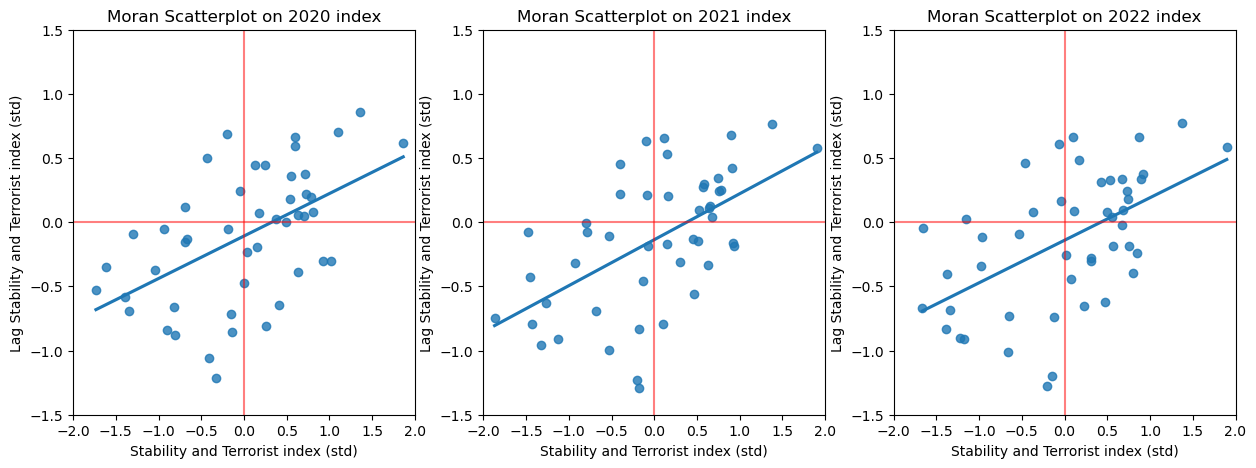

In [102]:
from pysal.lib import weights
f, axs = plt.subplots(1,3, figsize=(15, 5))
for i,year in enumerate(["2020", "2021", "2022"]):
    ax = axs[i]
    #ns, nw, _ = build_W(laginfo,year)
    ns, nw, _ = build_W(laginfo,year,noweight = True)
    w = W(ns, nw) # already row standardized by default
    y = st[year].values
    m = Moran(y, w)

    toplot = pd.DataFrame({"std_stability": y-y.mean(), "std_spatial_lag_stability": weights.lag_spatial(w,y-y.mean())})
    sb.regplot(x="std_stability", y="std_spatial_lag_stability", data=toplot, ci=None, ax=ax)
    # Add vertical and horizontal lines
    ax.axvline(0, c="red", alpha=0.5)
    ax.axhline(0, c="red", alpha=0.5)
    ax.set_xlabel("Stability and Terrorist index (std)")
    ax.set_ylabel("Lag Stability and Terrorist index (std)")
    ax.set_title(f"Moran Scatterplot on {year} index")
    ax.set_xlim((-2.,2.))
    ax.set_ylim((-1.5,1.5))
    
plt.savefig("./pics/moranscatter.png")

In [23]:
from pysal.explore import esda
from splot import esda as esdaplot

/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
geom = geometries[geometries.ISO.isin(common)]

Now saving 2020...


/tmp/ipykernel_13089/574734212.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geom.sort_values(by="ISO", inplace = True)
/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Now saving 2021...


/tmp/ipykernel_13089/574734212.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geom.sort_values(by="ISO", inplace = True)
/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Now saving 2022...


/tmp/ipykernel_13089/574734212.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geom.sort_values(by="ISO", inplace = True)
/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/giacomo/anaconda3/envs/datavis/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

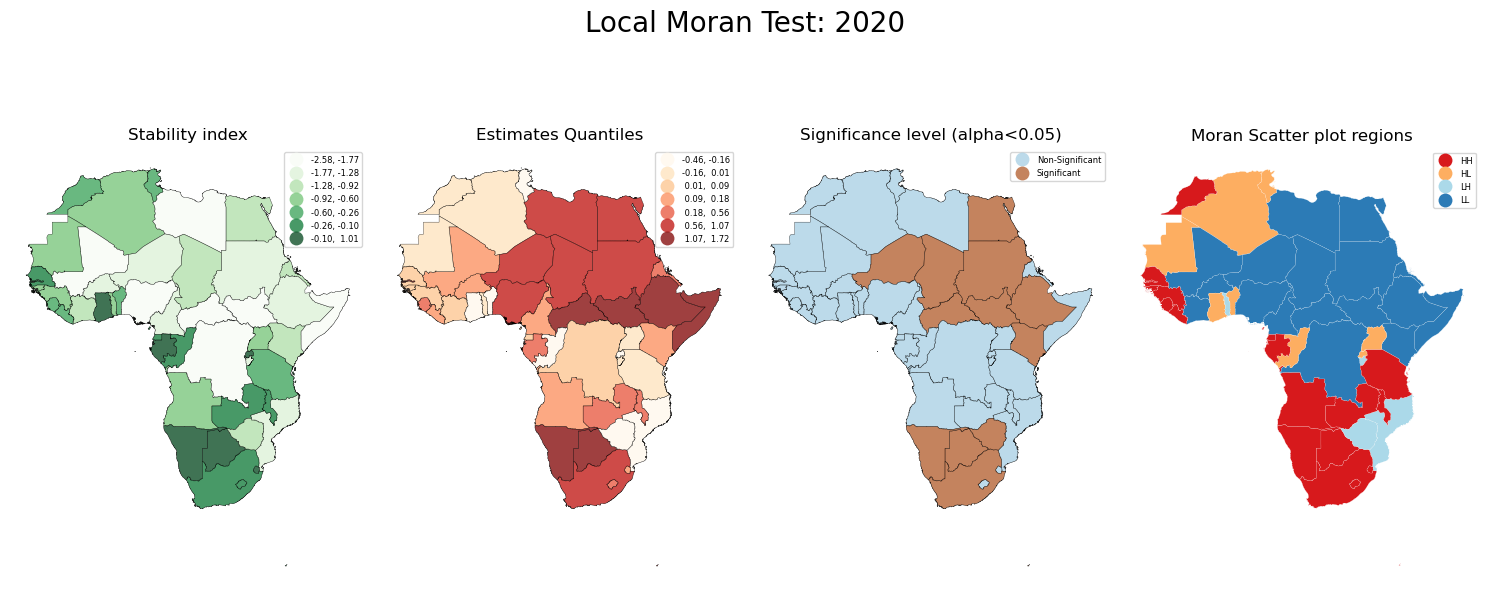

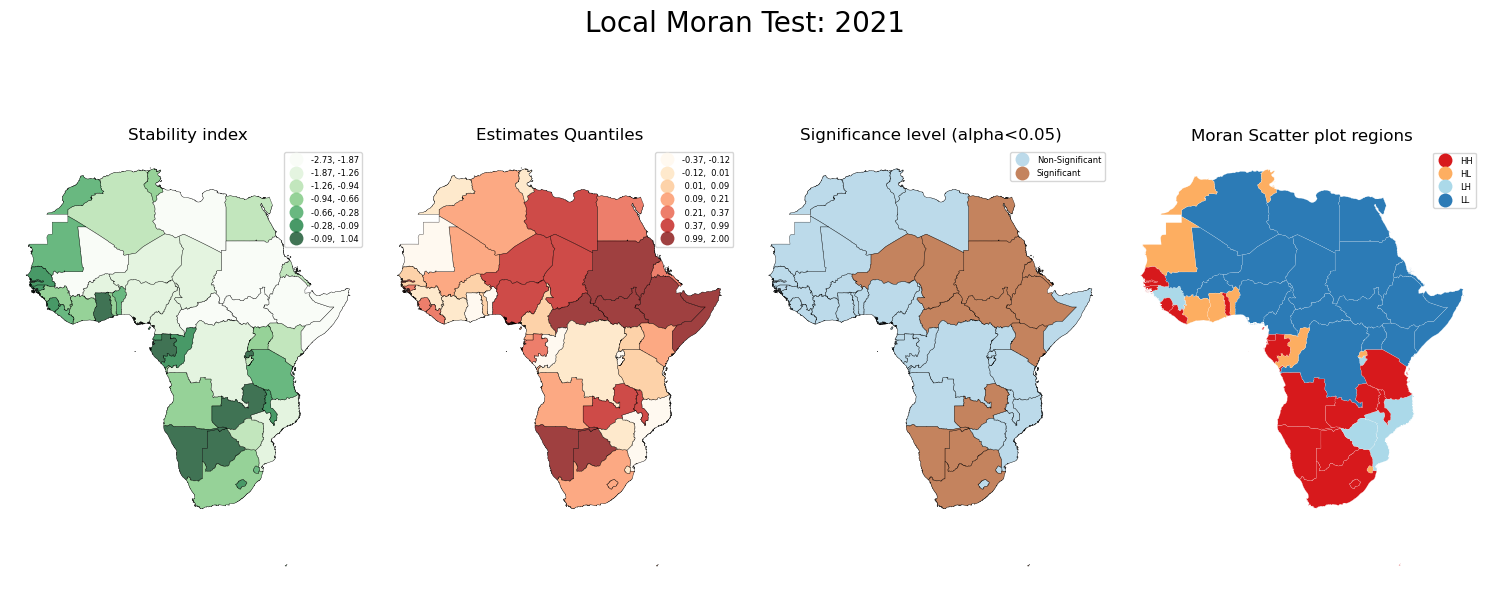

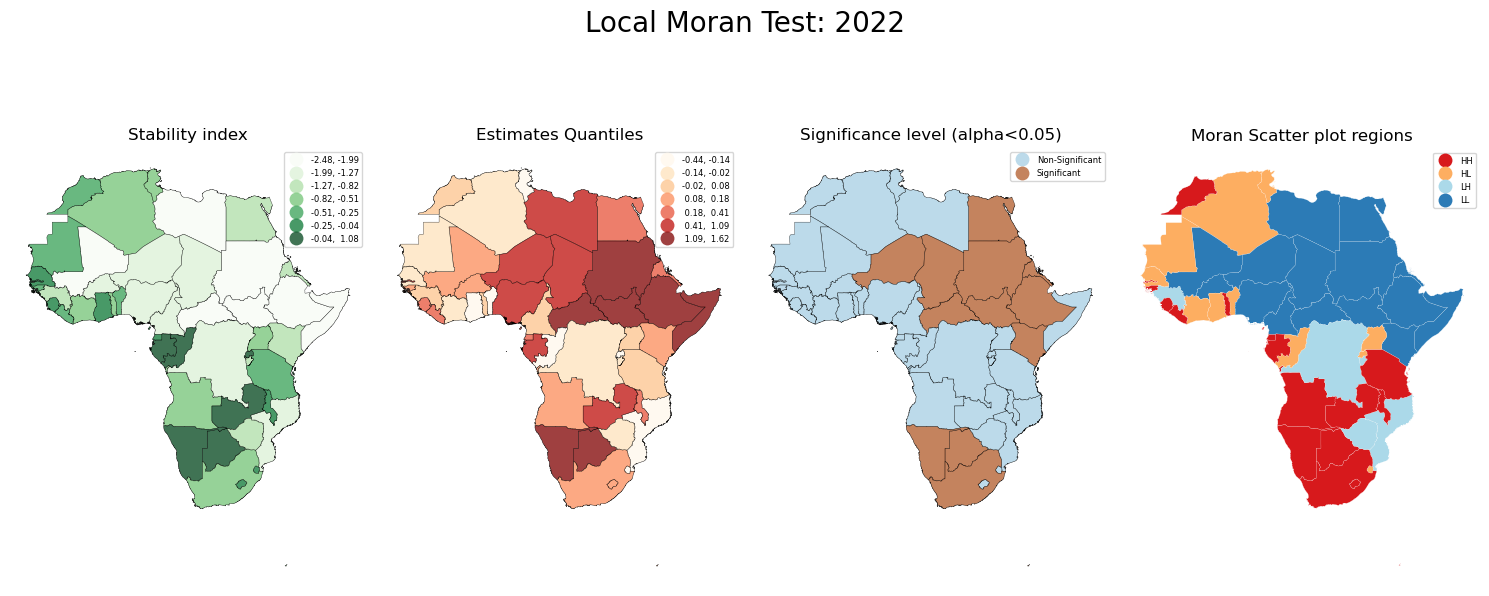

In [35]:
# Set up figure and axes

params = {'legend.fontsize': 6,
          'legend.handlelength': 2,
          'legend.loc':'lower right'}
plt.rcParams.update(params)

for year in ["2020", "2021", "2022"]:
    print(f"Now saving {year}...")
    #ns, nw, _ = build_W(laginfo,year)
    ns, nw, _ = build_W(laginfo,year,noweight = True)
    w = W(ns, nw) # already row standardized by default
    y = st[year].values
    lisa = esda.moran.Moran_Local(y, w)
    geom.sort_values(by="ISO", inplace = True)
    geom["Is"] = lisa.Is
    geom["sindex"] = y
    
    f, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 7))
    # Make the axes accessible with single indexing
    axs = axs.flatten()
 
    ax = axs[0]
    ax.axis('off')
    ax.set_title(f"Stability index")
    geom.plot(
        column="sindex", cmap="Greens", scheme="quantiles", k=7, edgecolor="black",
        linewidth=0.3, alpha=0.75, legend=True, ax=ax,
    )
    
    ax = axs[1]
    ax.axis('off')
    ax.set_title(f"Estimates Quantiles")
    geom.plot(
        column="Is", cmap="OrRd", scheme="quantiles", k=7, edgecolor="black",
        linewidth=0.3, alpha=0.75, legend=True, ax=ax,
    )

    ax = axs[2]
    ax.axis('off')
    ax.set_title(f"Significance level (alpha<0.05)")
    labels = pd.Series(1 * (lisa.p_sim < 0.05), index=geom.index).map({1: "Significant", 0: "Non-Significant"})
    geom["cl"] = labels
    geom.plot(column="cl", categorical=True, k=2, cmap="Paired", linewidth=0.3,
        edgecolor="black", alpha=0.75, legend=True, ax=ax,
    )
    
    ax = axs[3]
    ax.axis('off')
    ax.set_title(f"Moran Scatter plot regions")
    esdaplot.lisa_cluster(lisa, geom, p=1, legend=True, ax=ax)
    plt.suptitle(f"Local Moran Test: {year}", fontsize=20)
    f.tight_layout()
    plt.savefig(f"./pics/local_corr_{year}.png")

# Saving csv for spatial regression

In [205]:
final

NAME_0  Year  EventRoot5  EventRoot6  EventRoot7  EventRoot10  \
0      Angola  2020         790         301         405           98   
1      Angola  2021         583         161         259           57   
2      Angola  2022         537         183         193           43   
3     Burundi  2020         293         108         133           92   
4     Burundi  2021         234          55         124           29   
..        ...   ...         ...         ...         ...          ...   
139    Zambia  2021        1291         252         599          213   
140    Zambia  2022        1044         212         476          130   
141  Zimbabwe  2022        4072        1348        2161          820   
142  Zimbabwe  2020        4604        1958        3017         1320   
143  Zimbabwe  2021        4043        1410        2481          848   

     EventRoot12  EventRoot13  EventRoot14  EventRoot19  EventRoot20  \
0            225          108           83          335            1   
1            130           63           54          231            1   
2            183           39           78          250            0   
3            192           69           82          220            3   
4             51           39           14          141            1   
..           ...          ...          ...          ...          ...   
139          411          213          103          511            0   
140          258          159           70          496            0   
141         1237          623          377         2001            0   
142         2283         1106          806         3085           11   
143         1475          737          437         2392            2   

      AvgTone  GoldsteinScale  
0   -2.260883        0.626843  
1   -1.996263        0.617183  
2   -2.104010        0.630709  
3   -2.058220        0.689781  
4   -1.841849        0.923025  
..        ...             ...  
139 -1.934290        0.744490  
140 -1.584357        0.874271  
141 -2.739437        0.114748  
142 -2.638103        0.362789  
143 -2.508133        0.203774  

[144 rows x 13 columns]

In [213]:
final = final[final.ISO.isin(common)]

tosave = []
st.sort_values(by="ISO", inplace=True)
for year in ["2020","2021","2022"]:
    tosave.append(pd.DataFrame({"NAME_0":st.NAME_0,
                                "ISO":st.ISO,
                                "Year":year,
                                "stability":st[year]}))

    
pd.concat(tosave).to_csv("./data/stability_indexes.csv")
final.to_csv("./data/event_predictors.csv")